In [2]:
import os
import pickle
import pandas as pd
import numpy as np
from scipy.stats import stats

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.collections import PolyCollection
from matplotlib.colors import to_rgb
%matplotlib inline

from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from brainspace.datasets import load_parcellation
from enigmatoolbox.utils.parcellation import parcel_to_surface
import warnings
warnings.filterwarnings("ignore")

### Setting up dirs & Reading in tables

In [3]:
## set dirs
base_dir = '/Volumes/GoogleDrive/My Drive/Gradient_Shift_Cellular_Basis/Milgram'
gradient_dir = base_dir+'/data/Gradients_Margulies2016'
figure_dir = base_dir+'/figures/PredictingNetwork'
net_enrich_dir = base_dir+'/data/NetworkEnrichment'

In [4]:
## 1. load the 18 cell-types
LakeDFC_schaefer400 = pd.read_csv(gradient_dir+'/schaeffer_LAKE_DFC_400_7Net_expr_mat_new_NormZscore0.3.csv',header=None,index_col=0)
LakeVIS_schaefer400 = pd.read_csv(gradient_dir+'/schaeffer_LAKE_VIS_400_7Net_expr_mat_new_NormZscore0.3.csv',header=0,index_col=0)
# name list of row names (cell-type)
cell_types_DFC = list(LakeDFC_schaefer400.index.values)
cell_types_VIS = list(LakeVIS_schaefer400.index.values)
# drop NaN columns in empirical cell type fractions
LakeDFC_schaefer400_drop = LakeDFC_schaefer400.dropna(axis=1)
LakeVIS_schaefer400_drop = LakeVIS_schaefer400.dropna(axis=1)
# 0~190: LH
# 191~339: RH
# remove the Ex2 from DFC and In2 from VIS
LakeDFC_schaefer400_drop = LakeDFC_schaefer400_drop.drop(index=('DFC_Ex2'))
LakeVIS_schaefer400_drop = LakeVIS_schaefer400_drop.drop(index=('VIS_In2'))
# extract the values
LakeDFC_schaefer400_mat = LakeDFC_schaefer400_drop.to_numpy()
LakeVIS_schaefer400_mat = LakeVIS_schaefer400_drop.to_numpy()

## 2. load the labels for the Schaefer networks
schaefer400_7Networks = pd.read_csv(gradient_dir+'/schaefer_400_7Net_labels_manually_added.csv',header=None,index_col=0)
# dropped version of it
schaefer400_7Networks_drop = pd.read_csv(net_enrich_dir + '/schaefer400_7Networks_NaNDropped.csv',header=0,index_col=0)
schaefer400_7Networks_mat = schaefer400_7Networks_drop.to_numpy()
schaefer400_7Networks_mat_left = schaefer400_7Networks_mat[:191,:]

### funtions for processing & plotting

In [5]:
# download surfaces:
surfaces = fetch_fslr()
#surfaces = fetch_fslr(density='164k')
# check the available surfaces:
#surfaces.keys()
#---- output ----
# dict_keys(['midthickness', 'inflated', 'veryinflated', 'sphere', 'medial', 'sulc', 'vaavg'])
#---- output ----

# load schaefer parcellation labels (in fsaverage6)
lh_schaefer400, rh_schaefer400 = load_parcellation('schaefer')
# each vertex stores the corresponding parcel label
#lh_parc.shape
#---- output ----
# (32492,)
#---- output ----

# for gradients, vary inflated version can best visualize the details
lh, rh = surfaces['veryinflated']

vertex_per_hemi = len(lh_schaefer400)

schaefer400_7Networks_fsaverage6 = parcel_to_surface(schaefer400_7Networks[1].to_numpy(), 'schaefer_400_fsa6')

network_names = ['Visual','Som/Motor','DorsAttn','Sal/VentAttn','Limbic','Control','Default']

In [6]:
#function to compare performance between a pair of models 
def get_exact_p(x,y):
    pval = 2*np.min([np.mean(x-y>=0), np.mean(x-y<=0)])
    
    return pval

#function to compare perforance between a model and its null 
def get_null_p(x,null):
    pval = 1-np.mean((x-null)>=0)
    
    return pval

In [7]:
def Vec2Table_Recall(net_num, perm_num, recall_real, recall_null):
    '''
    perm_num: int, number of permuutations
    recall_real: 2D array (permutation x networks), recall of classifiers trained on real data
    recall_null: 2D array (permutation x networks), recall of classifiers trained on permutated data
    '''
    # combine the recall data into table
    net_labels = []
    hue_labels = []
    recalls = []
    for this_net in range(net_num):
        nets = []
        hue = []
        this_recall = []
        for this_perm in range(perm_num):
        
            this_recall.append(recall_real[this_perm,this_net])
            hue.append('real')
            nets.append(network_names[this_net])
        
            this_recall.append(recall_null[this_perm,this_net])
            hue.append('null')
            nets.append(network_names[this_net])
        
        net_labels = net_labels+nets
        hue_labels = hue_labels+hue
        recalls = recalls+this_recall
    
    # make as dataframe
    table = pd.DataFrame({'Recall':recalls, 'Network':net_labels, 'Model':hue_labels})
    return table

In [8]:
def ViolinPlot_Recall(data, fig_name, recall_real, recall_null):
    
    ## network parameters
    new_order = [1,0,2,3,5,6,4]
    reorder_net = [network_names[i] for i in new_order]
    
    # color code for the 7 networks (reordered version)
    yeo_cmap_RGB = [(70/255, 130/255, 180/255),
                    (120/255, 18/255, 134/255),
                    (0/255, 118/255, 14/255),
                    (196/255, 58/255, 250/255),
                    (230/255, 148/255, 34/255),
                    (205/255, 62/255, 78/255),
                    (220/255, 248/255, 164/255)]
    colors = sns.color_palette(yeo_cmap_RGB, 7) 
    
    ## plot parameters:
    nrows = 1
    ncols = 1
    dpi = 300
    tight = True

    x = 'Recall'
    y = 'Network'
    hue = 'Model'
    scale='width'
    orient = 'h'
    split = True
    inner = 'quartile'
    cut=0
    order = reorder_net
    
    ## make violin plot
    sns.set_style(style="white")
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, sharex=True, figsize=[5,7], dpi=dpi, constrained_layout=tight)
    #sns.set_style(style="white")
    ax = sns.violinplot(ax=ax, x=x, y=y, hue=hue, scale=scale, orient=orient, palette=['.4', '.7'], split=split,
                        data=table_DFC, order=order, inner=inner, cut=cut)
    ax.legend_.remove()
    
    # 1. make each network their unique color:
    for ind, violin in enumerate(ax.findobj(PolyCollection)):
        rgb = to_rgb(colors[ind // 2])
        if ind % 2 != 0:
            rgb = 0.5 + 0.5 * np.array(rgb) # make whiter #'grey'
        violin.set_facecolor(rgb)
        
    # 2. customize the quantile line style
    for l in ax.lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(1.2)
        l.set_color('black')
    
    # 3. add the grid
    lw = .5
    color = 'k'
    
    hline_positions = np.arange(0.5,7,1)
    for h in hline_positions:
        ax.axhline(h,  linewidth=lw, color=color, dashes=(1, 4))
        
    vline_positions = np.arange(0,1.2,0.2)
    for v in vline_positions:
        ax.axvline(v,  linewidth=lw, color=color, dashes=(1, 4))
    
    # add chance line
    ax.axvline(1/7,  linewidth=lw, color=color, dashes=(1, 0))
    
    # 4. add p-values
    text_positions = np.arange(-0.5,6.5,1)
    for net in range(net_num):
        this_net = new_order[net]
        p_null = get_null_p(recall_real[:,this_net],np.median(recall_null[:,this_net]))
        p_chance = get_null_p(recall_real[:,this_net],1/7)
        
        ax.text(0.8, text_positions[net]+0.11, f'p-null={np.round(p_null,3)}',fontsize=8)
        ax.text(0.8, text_positions[net]+0.22, f'p-chance={np.round(p_chance,3)}',fontsize=8)
        
    plt.savefig(figure_dir+f'/{fig_name}.pdf',transparent=True)

In [9]:
def ViolinPlot_Recall_2(data, fig_name, recall_real, recall_perm_null, recall_spin_null):
    
    ## network parameters
    new_order = [1,0,2,3,5,6,4]
    reorder_net = [network_names[i] for i in new_order]
    
    # color code for the 7 networks (reordered version)
    yeo_cmap_RGB = [(70/255, 130/255, 180/255),
                    (120/255, 18/255, 134/255),
                    (0/255, 118/255, 14/255),
                    (196/255, 58/255, 250/255),
                    (230/255, 148/255, 34/255),
                    (205/255, 62/255, 78/255),
                    (220/255, 248/255, 164/255)]
    colors = sns.color_palette(yeo_cmap_RGB, 7) 
    
    ## plot parameters:
    nrows = 1
    ncols = 1
    dpi = 300
    tight = True

    x = 'Recall'
    y = 'Network'
    hue = 'Model'
    scale='width'
    orient = 'h'
    split = True
    inner = 'quartile'
    cut=0
    order = reorder_net
    
    ## make violin plot
    sns.set_style(style="white")
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, sharex=True, figsize=[5,7], dpi=dpi, constrained_layout=tight)
    #sns.set_style(style="white")
    ax = sns.violinplot(ax=ax, x=x, y=y, hue=hue, scale=scale, orient=orient, palette=['.4', '.7'], split=split,
                        data=table_DFC, order=order, inner=inner, cut=cut)
    ax.legend_.remove()
    
    # 1. make each network their unique color:
    for ind, violin in enumerate(ax.findobj(PolyCollection)):
        rgb = to_rgb(colors[ind // 2])
        if ind % 2 != 0:
            rgb = 0.5 + 0.5 * np.array(rgb) # make whiter #'grey'
        violin.set_facecolor(rgb)
        
    # 2. customize the quantile line style
    for l in ax.lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(1.2)
        l.set_color('black')
    
    # 3. add the grid
    lw = .5
    color = 'k'
    
    hline_positions = np.arange(0.5,7,1)
    for h in hline_positions:
        ax.axhline(h,  linewidth=lw, color=color, dashes=(1, 4))
        
    vline_positions = np.arange(0,1.2,0.2)
    for v in vline_positions:
        ax.axvline(v,  linewidth=lw, color=color, dashes=(1, 4))
    
    # add chance line
    ax.axvline(1/7,  linewidth=lw, color=color, dashes=(1, 0))
    
    # 4. add p-values
    text_positions = np.arange(-0.5,6.5,1)
    for net in range(net_num):
        this_net = new_order[net]
        p_perm_null = get_null_p(recall_real[:,this_net],np.median(recall_perm_null[:,this_net]))
        p_spin_null = get_null_p(recall_real[:,this_net],np.median(recall_spin_null[:,this_net]))
        p_chance = get_null_p(recall_real[:,this_net],1/7)
        
        # order from relaxed to stringent
        if p_chance<0.001:
            ax.text(0.8, text_positions[net]+0.11, f'p-chance<0.001',fontsize=8)
        else:
            ax.text(0.8, text_positions[net]+0.11, f'p-chance={np.round(p_chance,3)}',fontsize=8)
            
        if p_perm_null<0.001:
            ax.text(0.8, text_positions[net]+0.22, f'p-perm<0.001',fontsize=8)
        else:
            ax.text(0.8, text_positions[net]+0.22, f'p-perm={np.round(p_perm_null,3)}',fontsize=8)
            
        if p_spin_null<0.001:
            ax.text(0.8, text_positions[net]+0.33, f'p-spin<0.001',fontsize=8)
        else:
            ax.text(0.8, text_positions[net]+0.33, f'p-spin={np.round(p_spin_null,3)}',fontsize=8)
        
        
    plt.savefig(figure_dir+f'/{fig_name}.pdf',transparent=True)

In [10]:
def SwapThomasNetOrder2FinalOrder(mat):
    # ThomasNetOrder: ['Visual','Som/Motor','DorsAttn','Sal/VentAttn','Limbic','Control','Default']
    # FinalNetOrder: ['Som/Motor','Visual','DorsAttn','Sal/VentAttn','Control','Default','Limbic']
    #1->20
    #2->1
    #20->2
    #5->70
    #6->5
    #7->6
    #70->7
    mat_final = np.copy(mat)
    mat_final[mat == 1] = 20
    mat_final[mat == 2] = 1
    mat_final[mat_final == 20] = 2
    mat_final[mat == 5] = 70
    mat_final[mat == 6] = 5
    mat_final[mat == 7] = 6
    mat_final[mat_final == 70] = 7
    return mat_final

In [11]:
def ConfusionMat(test_ori, pred_ori, file_name):
    
    test= SwapThomasNetOrder2FinalOrder(test_ori)
    pred = SwapThomasNetOrder2FinalOrder(pred_ori)
    
    net_names = ['Som/Motor','Visual','DorsAttn','Sal/VentAttn','Control','Default','Limbic']
    
    f, ax = plt.subplots(figsize = (7,7))
    cm = confusion_matrix(test.flatten(), pred.flatten())
    cm_norm = cm/np.tile(np.sum(cm,axis=1), (7,1)).T
    im=ax.imshow(cm_norm,cmap='hot')
    ax.set_xticks(np.arange(0,7,1))
    ax.set_xticklabels(net_names, rotation=90,fontsize=15)
    ax.set_yticks(np.arange(0,7,1))
    ax.set_yticklabels(net_names,fontsize=15)
    ax.set_xlabel('Predicted',fontsize=20)
    ax.set_ylabel('True',fontsize=20)
    ax.set_title('Confusion Matrix',fontsize=20)
    f.colorbar(im, ax=ax,shrink=.5)
    plt.show()
    f.savefig(figure_dir+f'/{file_name}.pdf',bbox_inches="tight",transparent=True)

In [12]:
def ParcelAccuracy(clf_num, parcel_num, test_parcel_num, net_num, Networks_Label, 
                   clf_pred_DFC, clf_pred_VIS, clf_pred_Both,clf_sample_test,
                   null_pred_DFC, null_pred_VIS, null_pred_Both,null_sample_test):
    # creat the list of parcels
    predicted_parcel_DFC = []
    predicted_parcel_VIS = []
    predicted_parcel_Both = []
    null_parcel_DFC = []
    null_parcel_VIS = []
    null_parcel_Both = []
    for c in range(parcel_num):
        predicted_parcel_DFC.append([])
        predicted_parcel_VIS.append([])
        predicted_parcel_Both.append([])
        null_parcel_DFC.append([])
        null_parcel_VIS.append([])
        null_parcel_Both.append([])
    
    # loop through all the calssifiers
    for p in range(clf_num):
        # loop through all the test parcels:
        for i in range(test_parcel_num):
            # get the index of this parcel
            idx = int(clf_sample_test[i,p])
            # get the corresponding predicted label
            pred = int(clf_pred_DFC[i,p])
            predicted_parcel_DFC[idx].append(pred)
            pred = int(clf_pred_VIS[i,p])
            predicted_parcel_VIS[idx].append(pred)
            pred = int(clf_pred_Both[i,p])
            predicted_parcel_Both[idx].append(pred)
            # get the corresponding predicted label
            idx = int(null_sample_test[i,p])
            pred = int(null_pred_DFC[i,p])
            null_parcel_DFC[idx].append(pred)
            pred = int(null_pred_VIS[i,p])
            null_parcel_VIS[idx].append(pred)
            pred = int(null_pred_Both[i,p])
            null_parcel_Both[idx].append(pred)

    # calculate the prediction accuracy for each parcel
    parcel_accuracy_DFC = []
    parcel_accuracy_VIS = []
    parcel_accuracy_Both = []
    parcel_null_DFC = []
    parcel_null_VIS = []
    parcel_null_Both = []
    for p in range(parcel_num):
        true_label = Networks_Label[p][0]
        parcel_accuracy_DFC.append(np.sum(np.asarray(predicted_parcel_DFC[p])==true_label)/len(predicted_parcel_DFC[p]))
        parcel_accuracy_VIS.append(np.sum(np.asarray(predicted_parcel_VIS[p])==true_label)/len(predicted_parcel_VIS[p]))
        parcel_accuracy_Both.append(np.sum(np.asarray(predicted_parcel_Both[p])==true_label)/len(predicted_parcel_Both[p]))
        parcel_null_DFC.append(np.sum(np.asarray(null_parcel_DFC[p])==true_label)/len(null_parcel_DFC[p]))
        parcel_null_VIS.append(np.sum(np.asarray(null_parcel_VIS[p])==true_label)/len(null_parcel_VIS[p]))
        parcel_null_Both.append(np.sum(np.asarray(null_parcel_Both[p])==true_label)/len(null_parcel_Both[p]))
        
    return parcel_accuracy_DFC,parcel_accuracy_VIS,parcel_accuracy_Both,parcel_null_DFC,parcel_null_VIS,parcel_null_Both

In [13]:
def SurfPlot_left(parcel_accuracy, full_parcel_table, file_name):
    # Fill the parcel accuracy back to surface
    left = np.zeros(200)
    arr = np.asarray(parcel_accuracy)
    arr[arr==0] = 0.0001
    left[full_parcel_table.loc[:,:200].notnull().any()] = list(arr)
    left = parcel_to_surface(np.concatenate((left,np.zeros(200)),axis=0), 'schaefer_400_fsa6')
    
    # set up the surface plot base
    p_left = Plot(surf_lh=lh,size=(1400, 500), zoom=1.7)
    lh_left = left[:vertex_per_hemi]
    # add layer for the K-Means Label
    p_left.add_layer(np.transpose(lh_left), cmap='hot') #cbar_label='Default mode'
    # add layer for the schaefer 400 pacels outline
    p_left.add_layer(lh_schaefer400, cmap='gray', as_outline=True, cbar=False)
    # set label properties
    kws = {'location': 'left',  'decimals': 2, 'shrink': .5,
           'fontsize': 15, 'n_ticks': 3, 'aspect': 10,
           'draw_border': True} #'label_direction': 45,'shrink': .15,
    fig = p_left.build(cbar_kws=kws)
    fig.savefig(figure_dir+f'/{file_name}.pdf',transparent=True)

In [14]:
def SurfPlot_full(parcel_accuracy, full_parcel_table, file_name):

    # Fill the cluster membership back to surface
    full = np.zeros(400)
    arr = np.asarray(parcel_accuracy)
    arr[arr==0] = 0.0001
    full[full_parcel_table.notnull().any()] = list(arr)
    full = parcel_to_surface(np.concatenate((full,np.zeros(400)),axis=0), 'schaefer_400_fsa6')

    # set up the surface plot base
    p_full = Plot(lh, rh,size=(1400, 1000), zoom=1.7)
    lh_full = full[:vertex_per_hemi]
    rh_full = full[vertex_per_hemi:]
    # add layer for the K-Means Label
    p_full.add_layer({'left': np.transpose(lh_full), 'right': np.transpose(rh_full)}, cmap='hot') #cbar_label='Default mode'
    # add layer for the schaefer 400 pacels outline
    p_full.add_layer({'left':lh_schaefer400, 'right':rh_schaefer400}, cmap='gray', as_outline=True, cbar=False)
    # set label properties
    kws = {'decimals': 2, 'shrink': .5,
           'fontsize': 15, 'n_ticks': 3, 'aspect': 10,
           'draw_border': True} #'label_direction': 45,'shrink': .15,
    fig = p_full.build(cbar_kws=kws)#
    fig.savefig(figure_dir+f'/{file_name}.pdf',transparent=True)

In [15]:
def WithinNetworkParcelAccuracyStats(parcel_accuracy,network_labels,filename):
    
    # combine the network labels and parcel accuracies into a DataFrame
    df = pd.DataFrame(data={'labels': network_labels, 'accracy': parcel_accuracy})

    # group by networks and report the mean, max and min accracy
    mean_net_parcel_accuracy = df.groupby('labels')['accracy'].mean()
    max_net_parcel_accuracy = df.groupby('labels')['accracy'].max()
    min_net_parcel_accuracy = df.groupby('labels')['accracy'].min()
    std_net_parcel_accuracy = df.groupby('labels')['accracy'].std()

    net_stats_parcel_accuracy = pd.DataFrame({'networks': network_names, 
                                              'mean': mean_net_parcel_accuracy,
                                              'max': max_net_parcel_accuracy,
                                              'min': min_net_parcel_accuracy,
                                              'std':std_net_parcel_accuracy})
    net_stats_parcel_accuracy.to_csv(figure_dir+filename+'.csv', index=True)
    return net_stats_parcel_accuracy

In [16]:
def F1DistPlot(null,clf,p,fig_name):
    # plot parameters:
    nrows = 1
    ncols = 1
    dpi = 300
    tight = True
    # set up the figure
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, sharex=True, figsize=[5,5], dpi=dpi, constrained_layout=tight)
    # set up layout
    sns.set_style(style="white")
    
    # make plot
    sns.kdeplot(null, color="grey",fill=True,ax=ax)
    sns.kdeplot(clf, color="b",fill=True,ax=ax)
    # set font size labels for x and y axis
    ax.set_xlabel('F-1 score', fontsize=18)
    ax.set_ylabel('Probability Density', fontsize=18)
    # set title
    if p<0.001:
        ax.set_title(f'p-spin<0.001',fontsize=18)
    else:
        ax.set_title(f'p-spin={np.round(p,3)}',fontsize=18)
    # set legend
    ax.legend(['Null','Empirical'])
    
    # save
    plt.savefig(figure_dir+f'/{fig_name}.pdf',transparent=True)

## Left Hemisphere

In [56]:
# load the results
clf_test, clf_sample_test, clf_pred_Both, clf_score_Both, clf_recall_Both, clf_pred_DFC, clf_score_DFC, clf_recall_DFC, C_best_DFC, gamma_best_DFC, kernel_best_DFC, degree_best_DFC, clf_pred_VIS, clf_score_VIS, clf_recall_VIS, C_best_VIS, gamma_best_VIS, kernel_best_VIS, degree_best_VIS = pickle.load(open(net_enrich_dir+'/1000ClassifiersBalancedEnsembeled_Left_2.pkl',"rb"))

# load the nulls
spin_test, spin_sample_test, spin_pred_Both, spin_score_Both, spin_recall_Both, spin_pred_DFC, spin_score_DFC, spin_recall_DFC, spin_pred_VIS, spin_score_VIS, spin_recall_VIS = pickle.load(open(net_enrich_dir+'/1000NullsBalancedSpinEnsembeled_Left_2.pkl',"rb"))

perm_test, perm_sample_test, perm_pred_Both, perm_score_Both, perm_recall_Both,perm_pred_DFC, perm_score_DFC, perm_recall_DFC, perm_pred_VIS, perm_score_VIS, perm_recall_VIS = pickle.load(open(net_enrich_dir+'/1000NullsBalancedPermEnsembeled_Left_2.pkl',"rb"))


### Over all performance: f-1 macro score

In [57]:
# p-value for performance
p_null_DFC = get_null_p(np.asarray(clf_score_DFC),np.median(spin_score_DFC))
p_null_VIS = get_null_p(np.asarray(clf_score_VIS),np.median(spin_score_VIS))
p_null_Both = get_null_p(np.asarray(clf_score_Both),np.median(spin_score_Both))

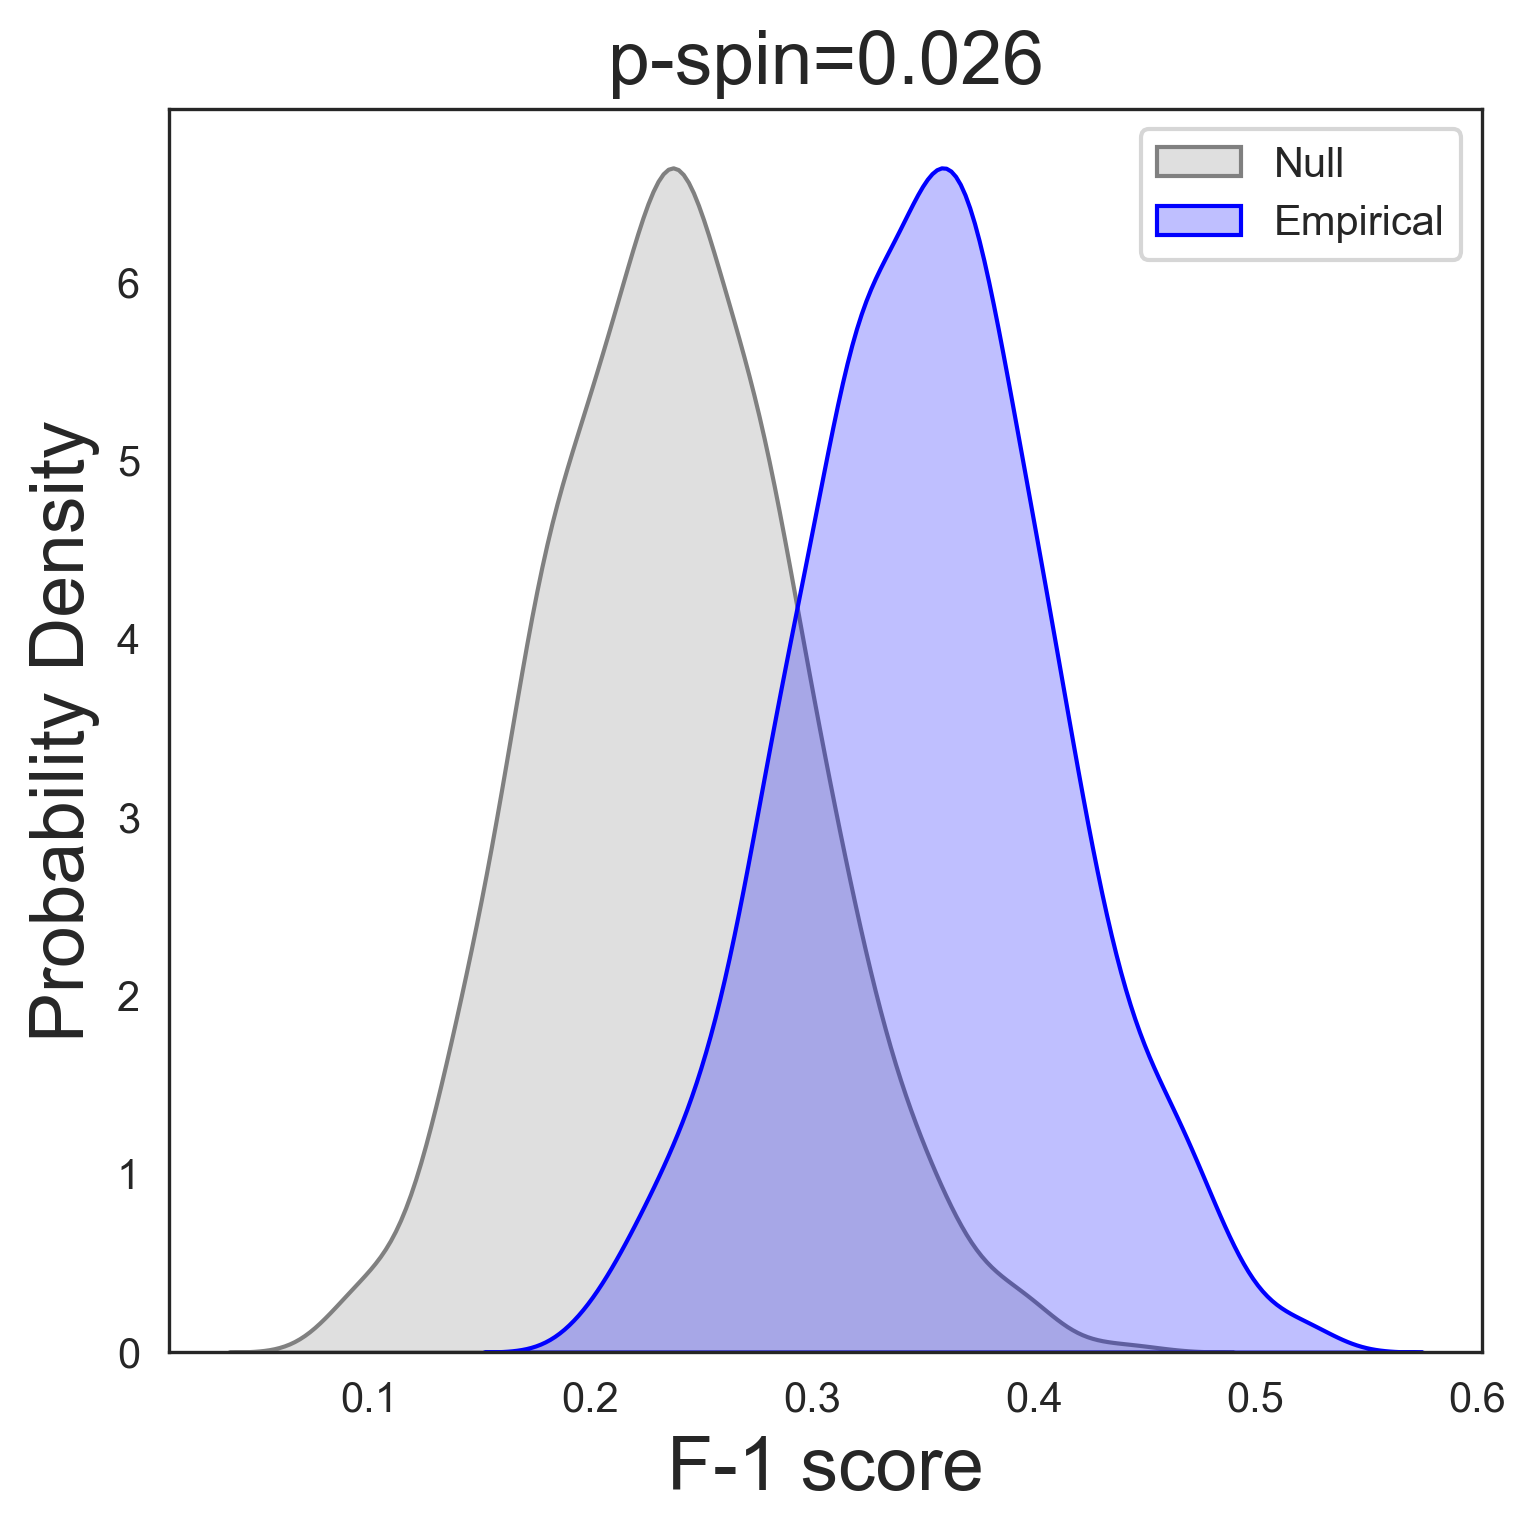

In [26]:
null = spin_score_DFC
clf = clf_score_DFC
p = p_null_DFC
fig_name = 'F1_DistPlot_DFC_spin_left'
F1DistPlot(null,clf,p,fig_name)

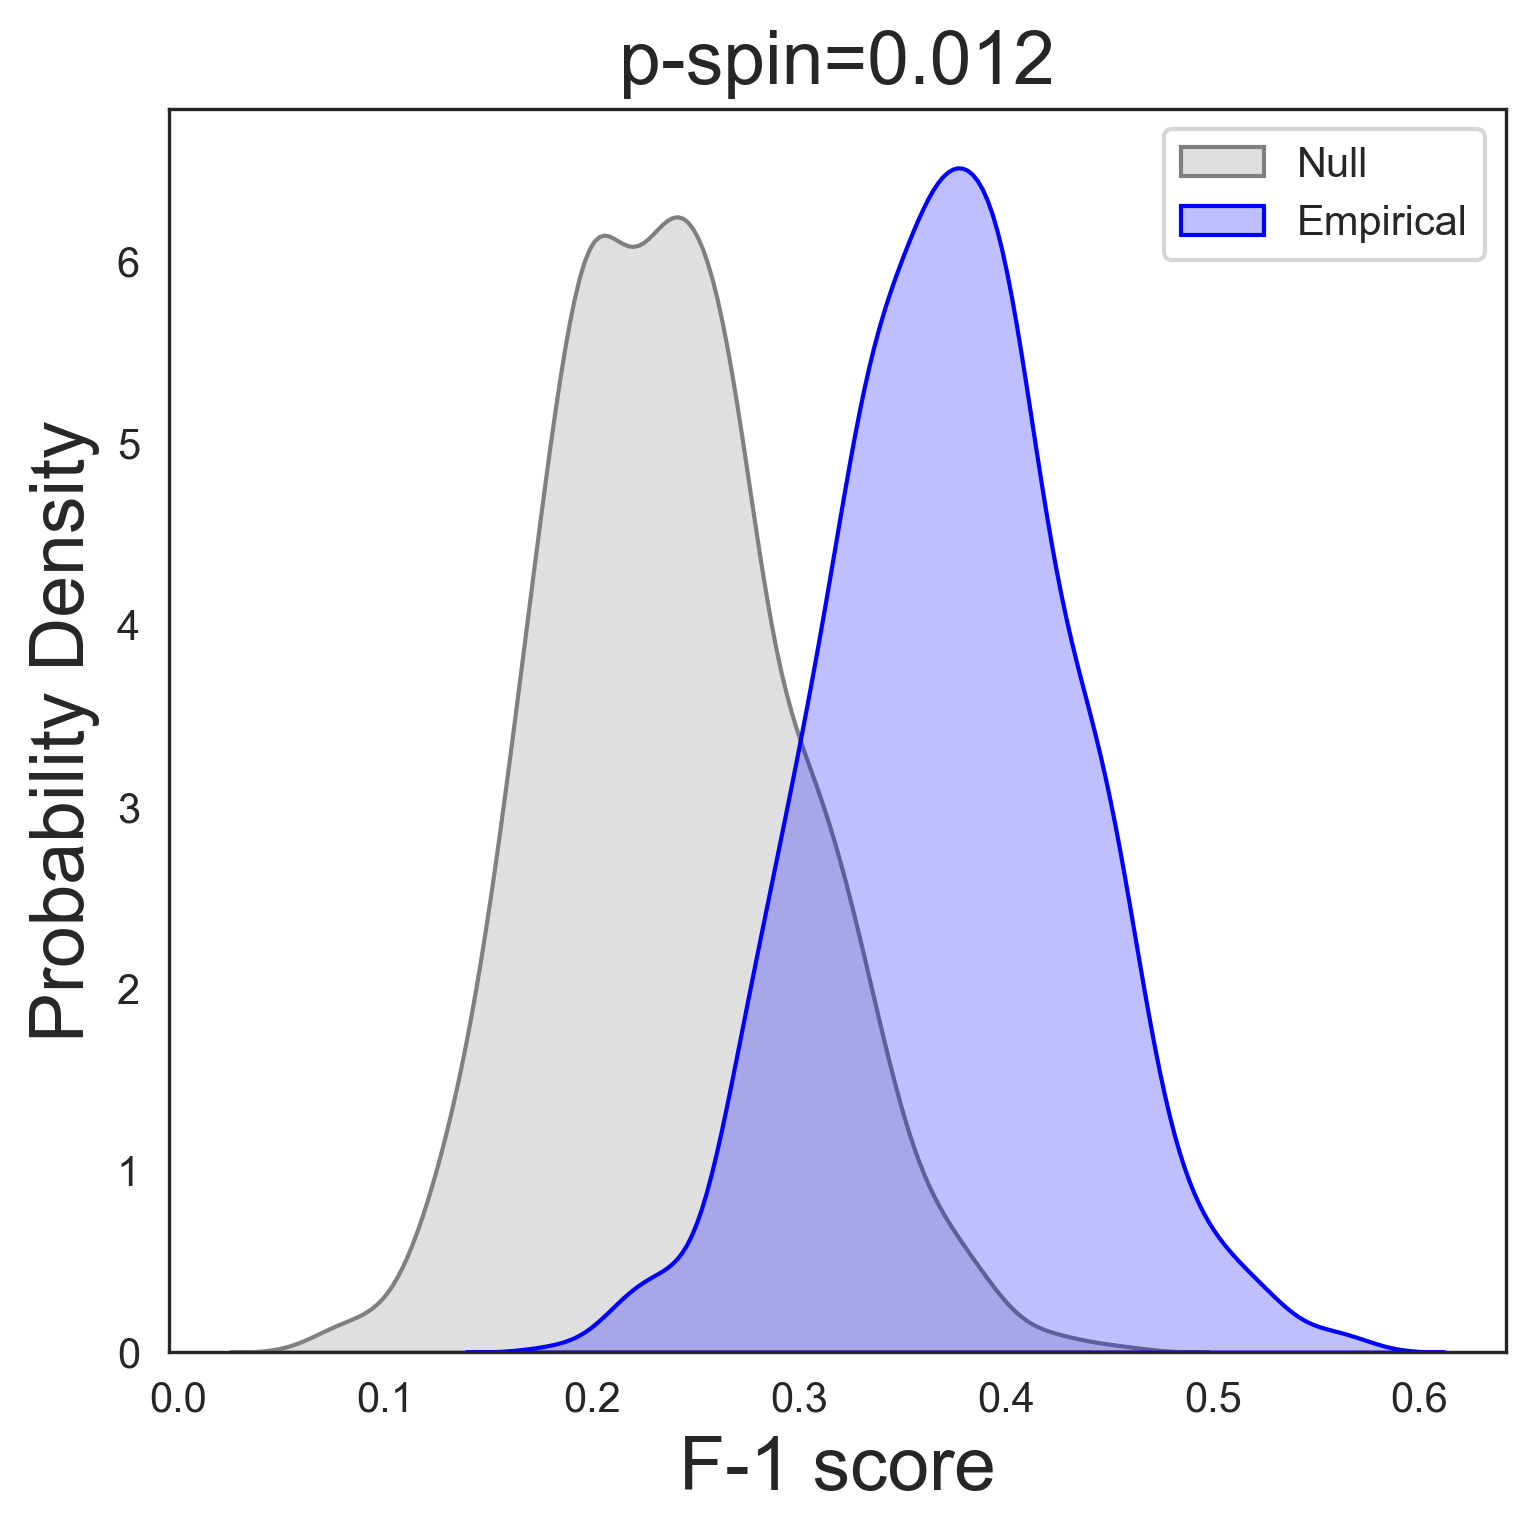

In [27]:
null = spin_score_VIS
clf = clf_score_VIS
p = p_null_VIS
fig_name = 'F1_DistPlot_VIS_spin_left'
F1DistPlot(null,clf,p,fig_name)

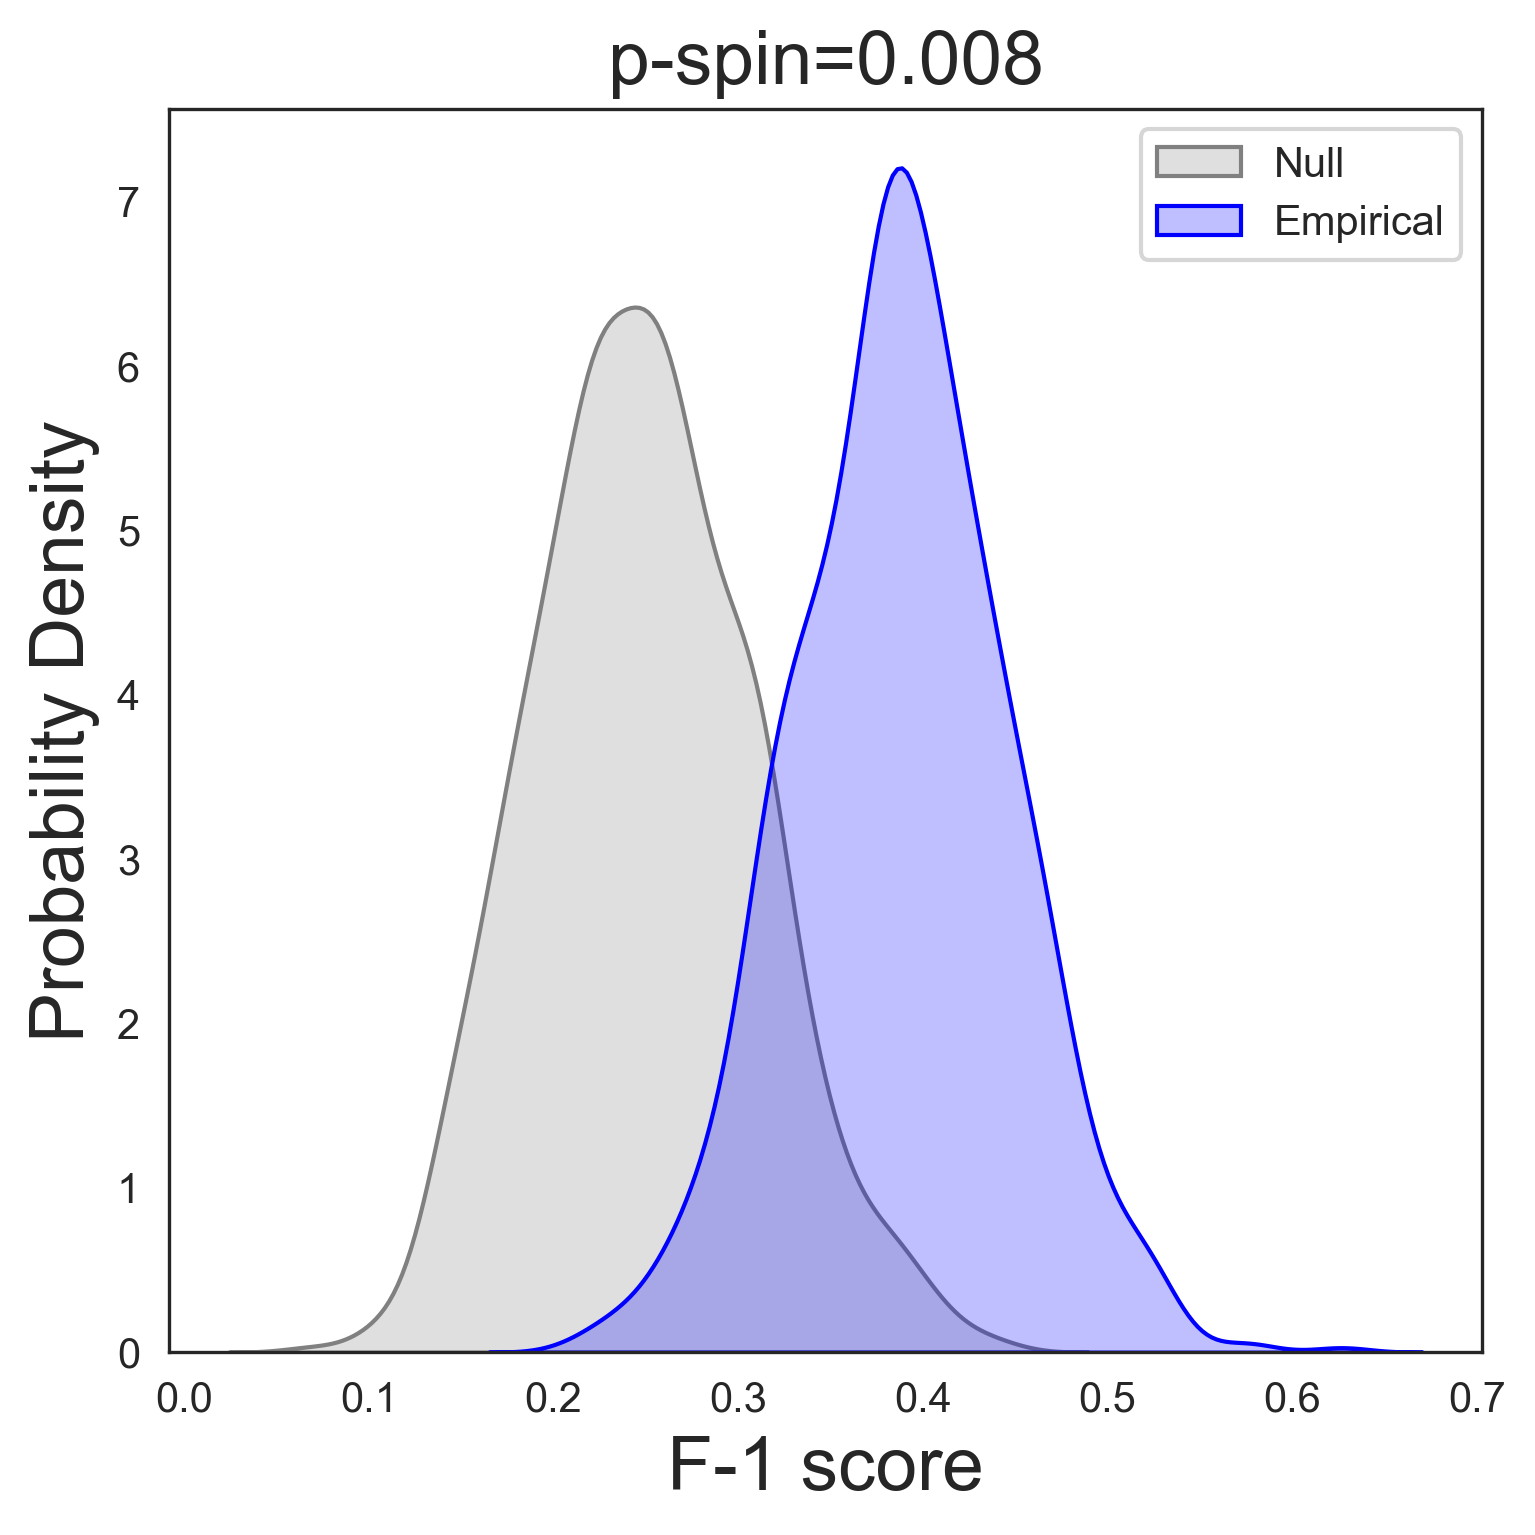

In [28]:
null = spin_score_Both
clf = clf_score_Both
p = p_null_Both
fig_name = 'F1_DistPlot_Ensembled_spin_left'
F1DistPlot(null,clf,p,fig_name)

### Within network performance: recall

In [29]:
net_num = 7
perm_num = 1000

table_Both = Vec2Table_Recall(net_num, perm_num, clf_recall_Both, spin_recall_Both)
table_DFC = Vec2Table_Recall(net_num, perm_num, clf_recall_DFC, spin_recall_DFC)
table_VIS = Vec2Table_Recall(net_num, perm_num, clf_recall_VIS, spin_recall_VIS)

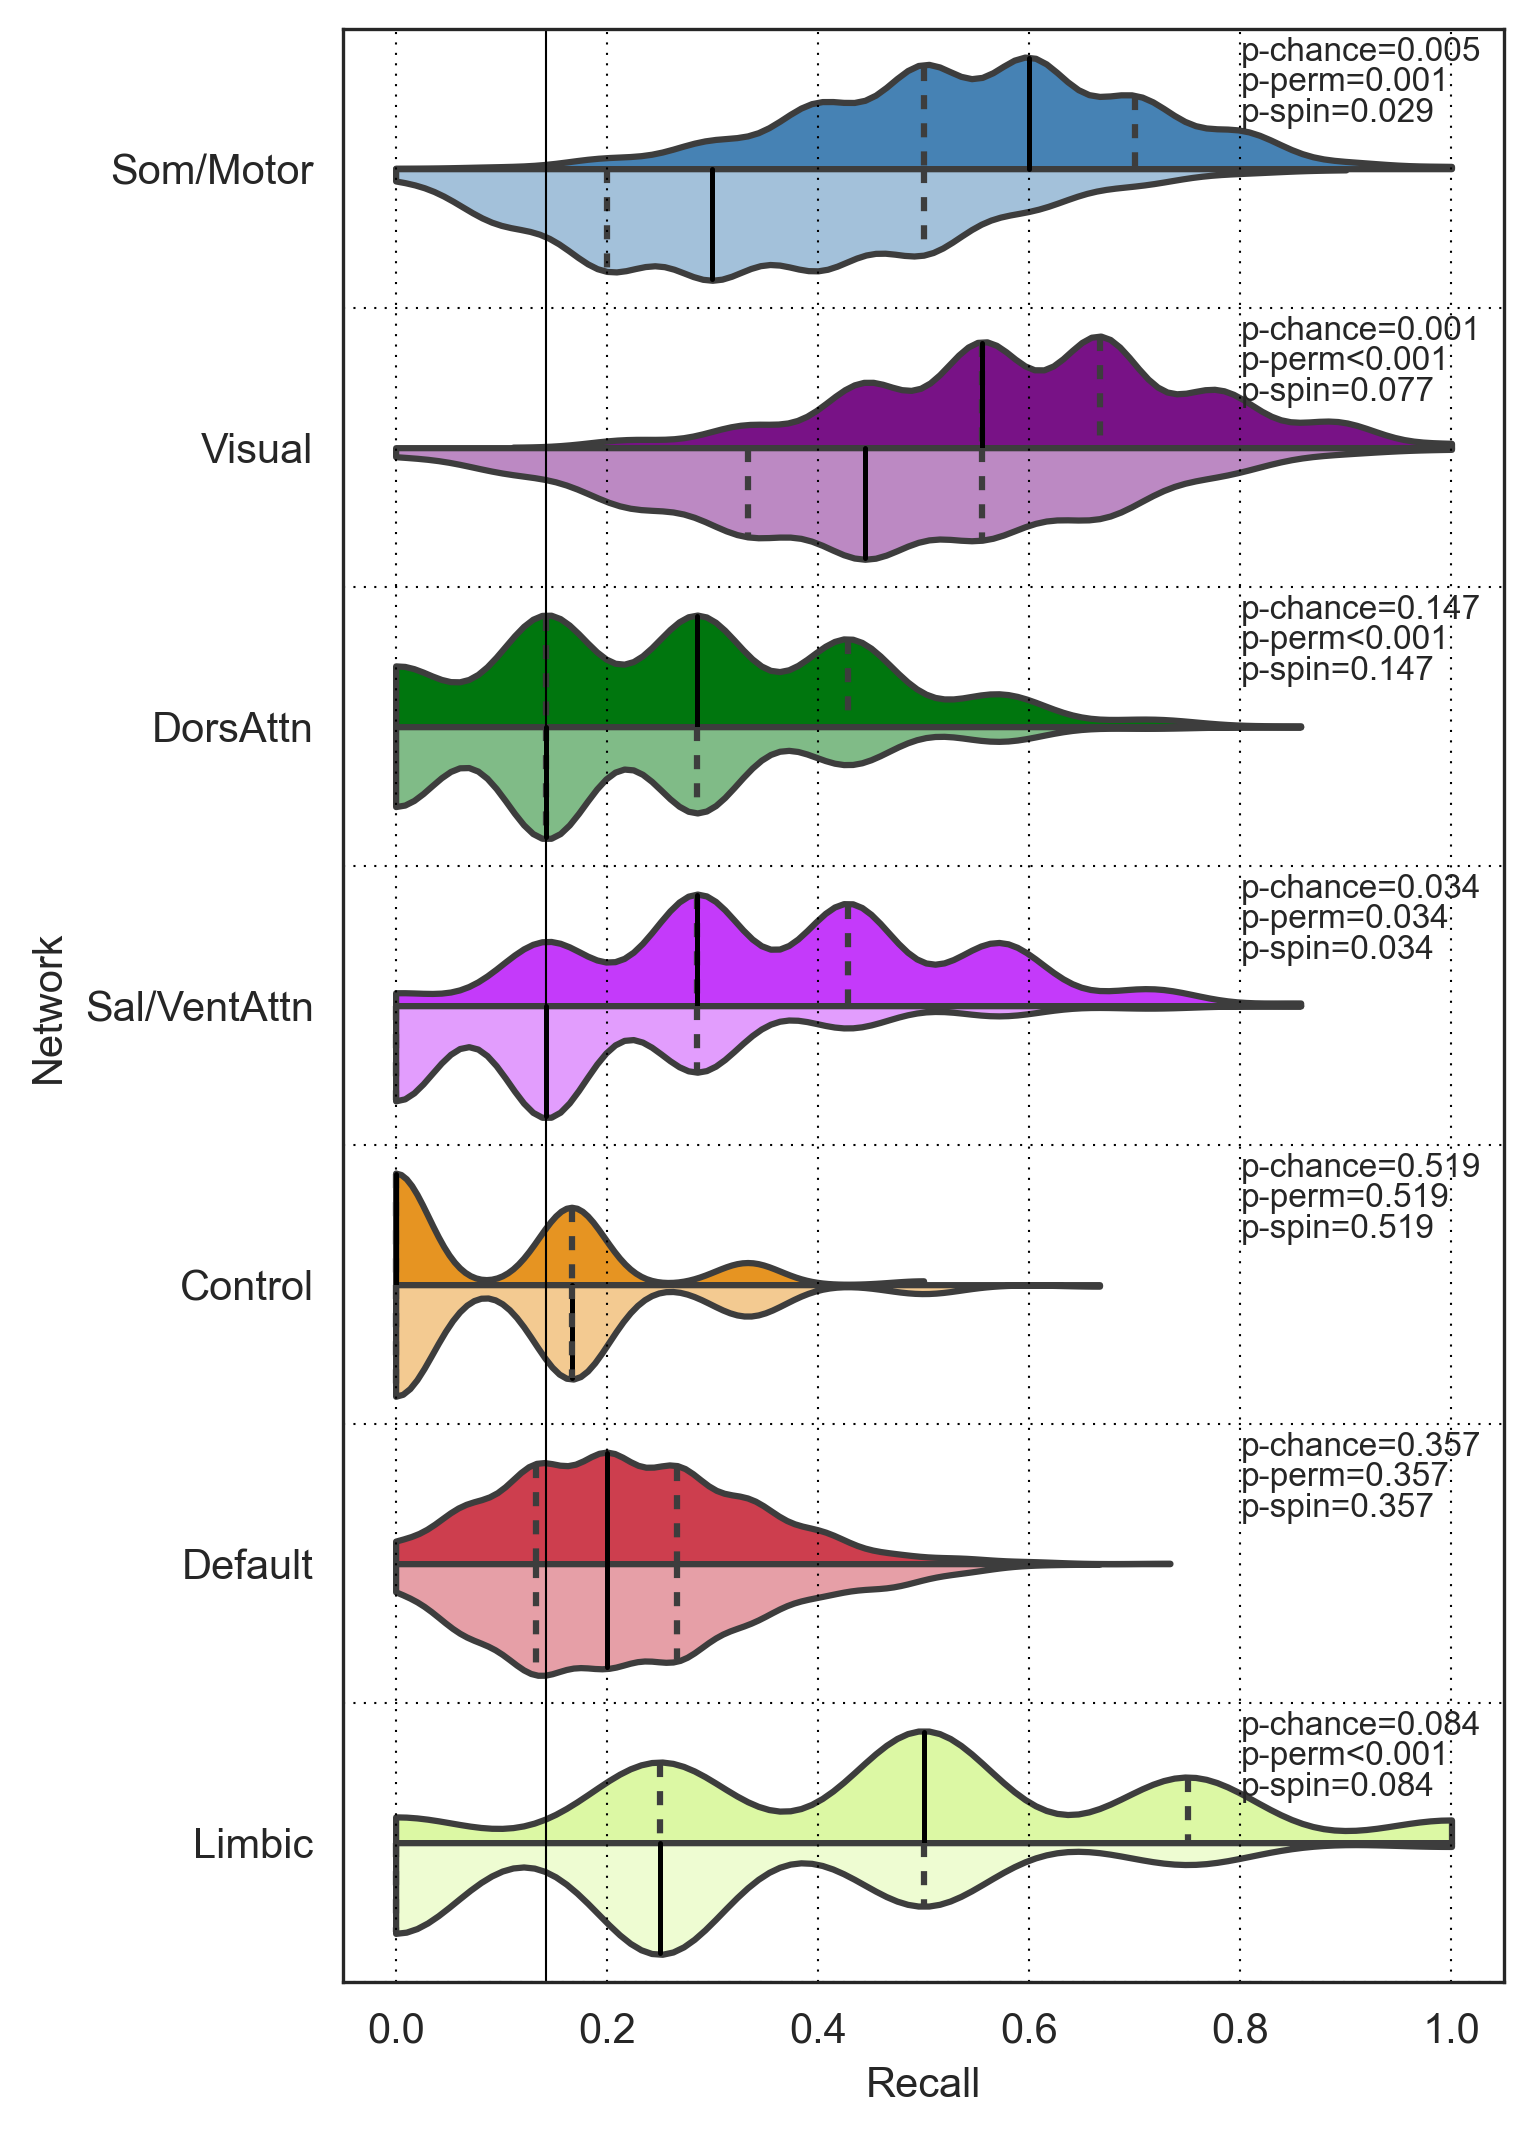

In [30]:
ViolinPlot_Recall_2(table_DFC,'Recall_ViolinPlot_DFC_spin_left',clf_recall_DFC,perm_recall_DFC,spin_recall_DFC)

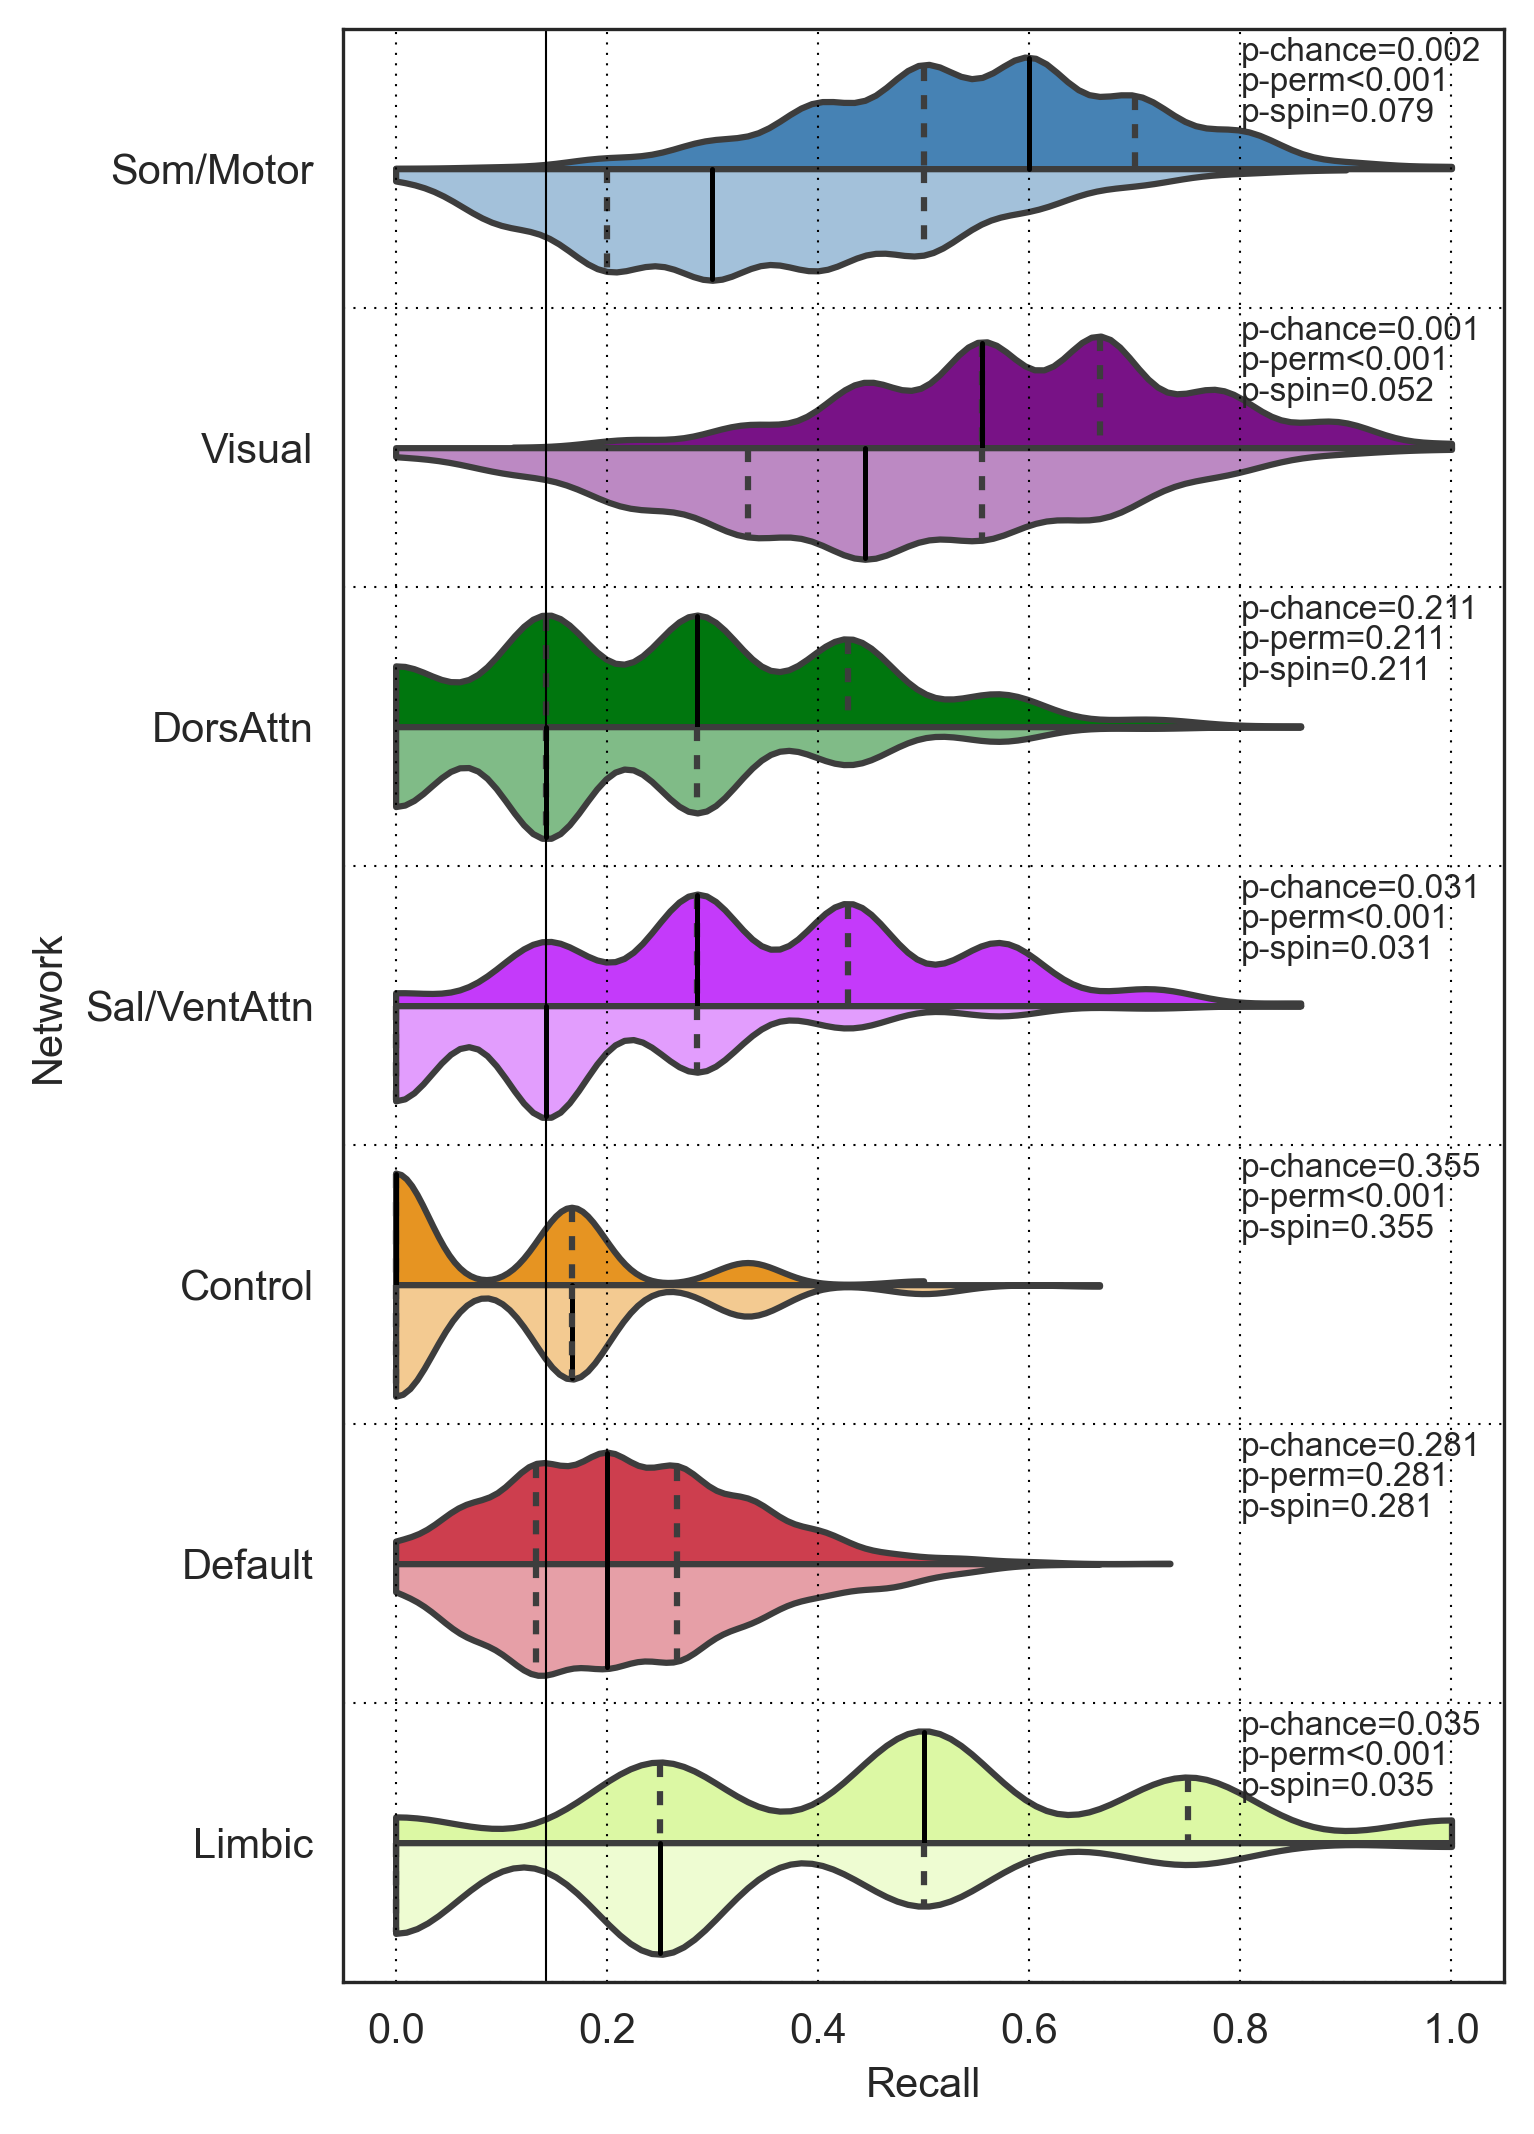

In [31]:
ViolinPlot_Recall_2(table_VIS,'Recall_ViolinPlot_VIS_spin_left',clf_recall_VIS,perm_recall_VIS,spin_recall_VIS)

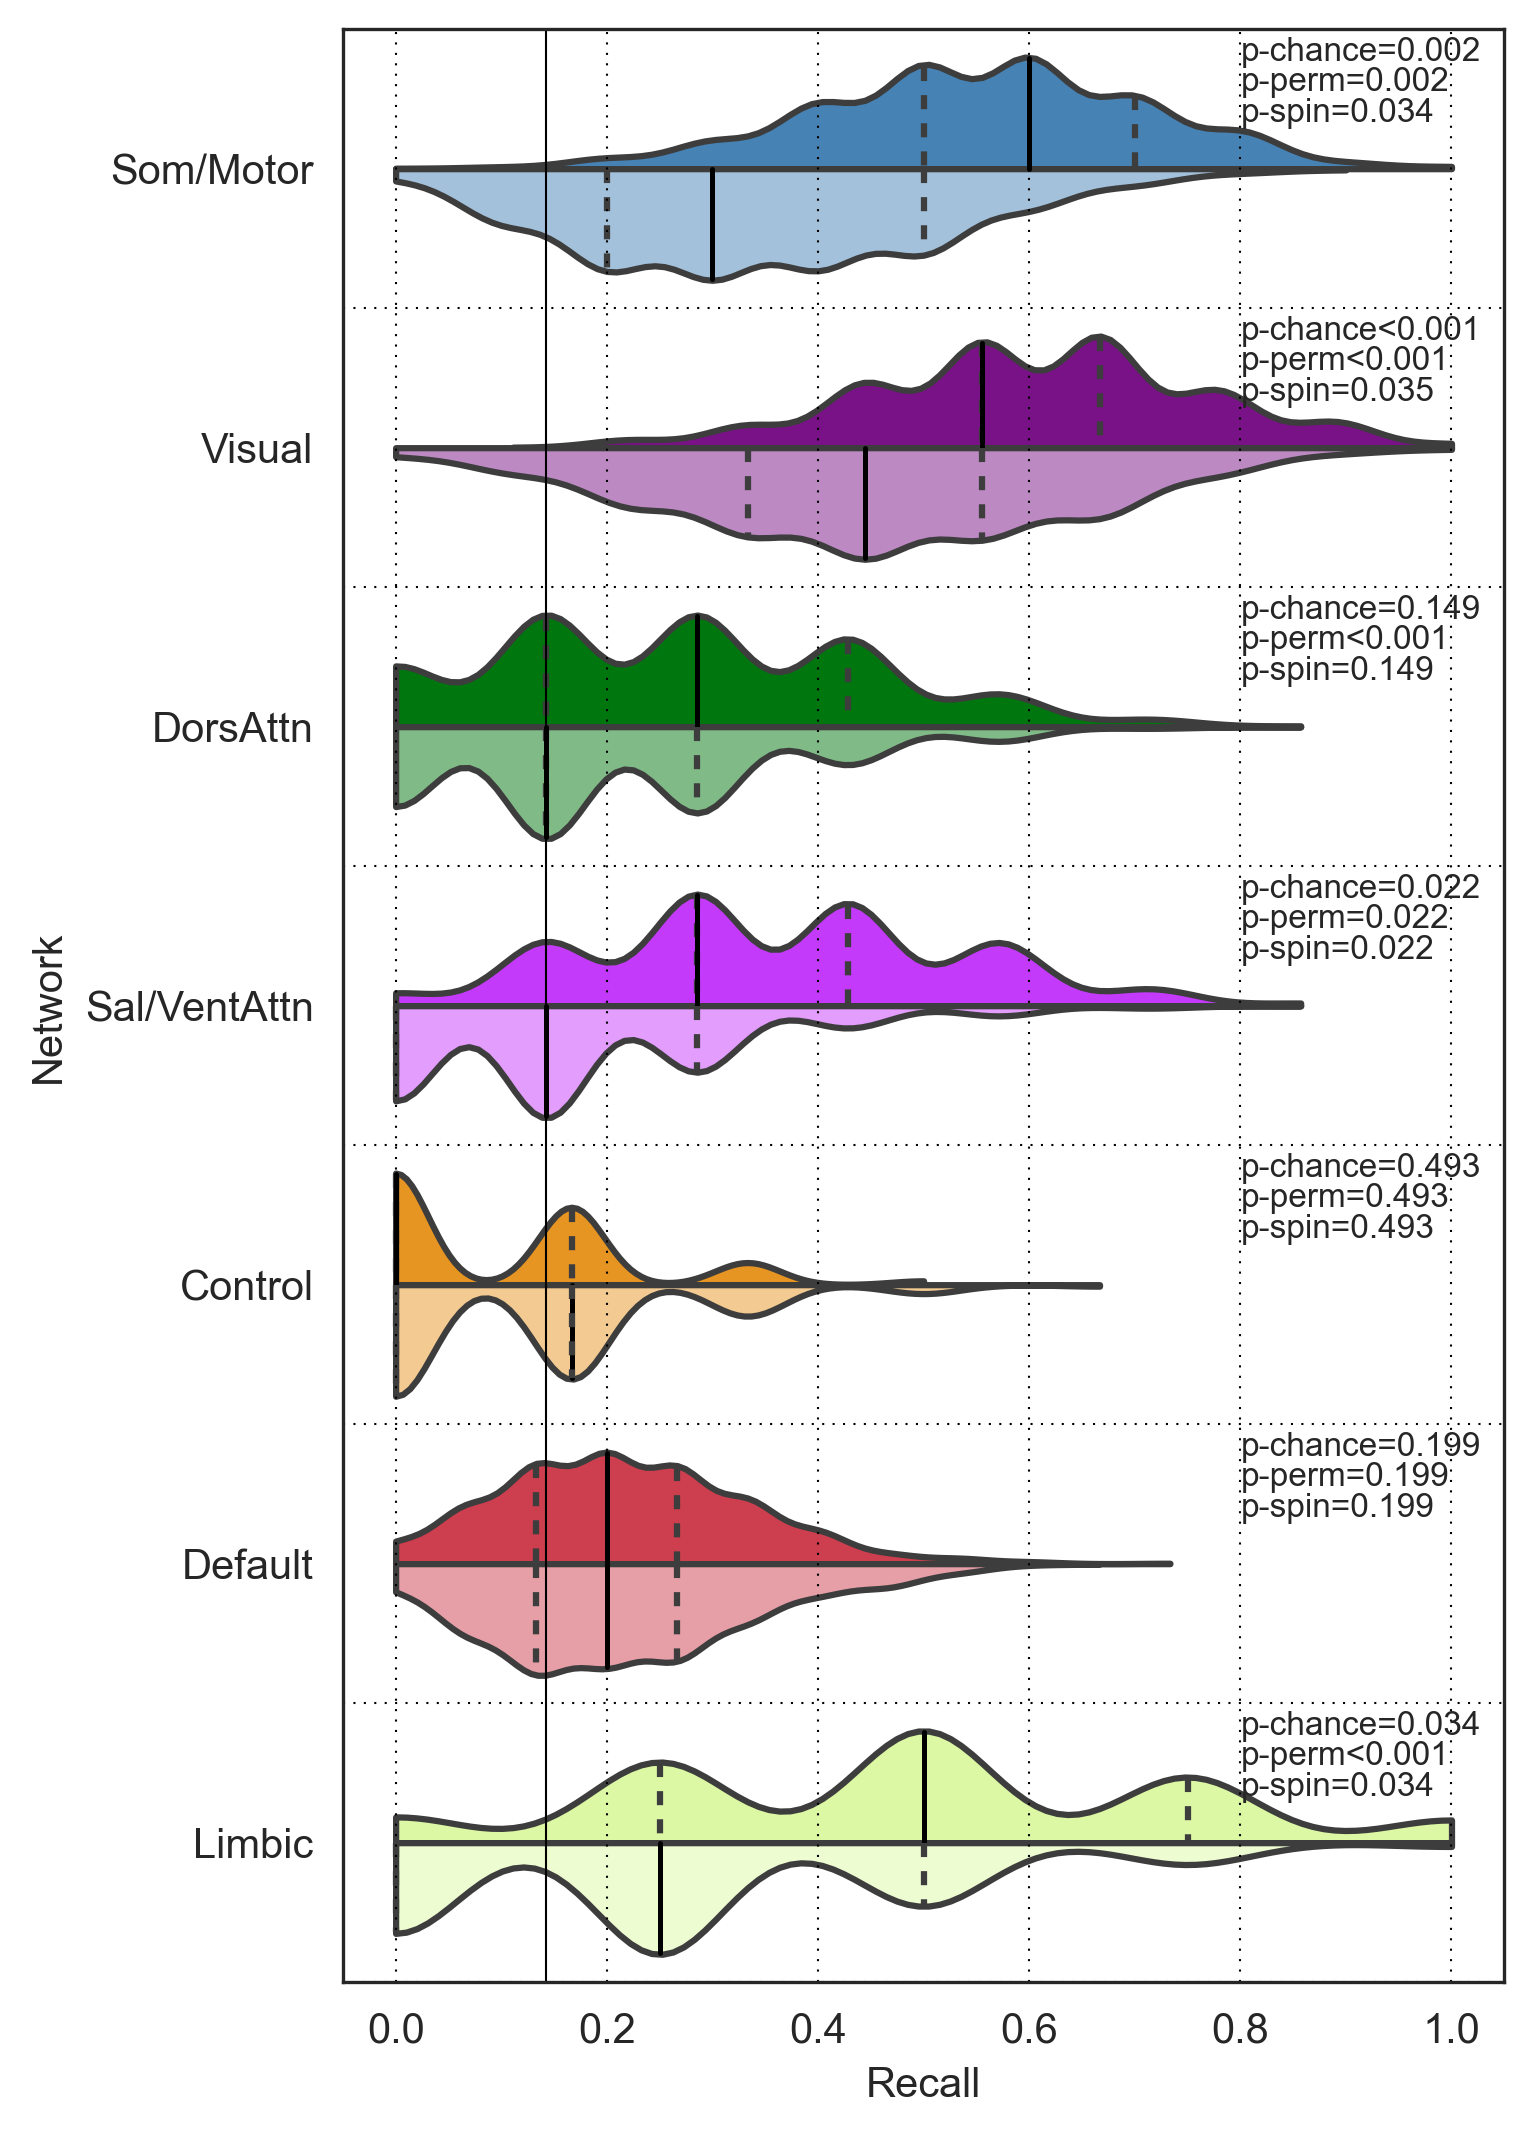

In [32]:
ViolinPlot_Recall_2(table_Both,'Recall_ViolinPlot_Ensembled_spin_left',clf_recall_Both,perm_recall_Both,spin_recall_Both)

### Parcel level accuracy
Use list to store all the predicted label for each parcel

#### Confusion matrix

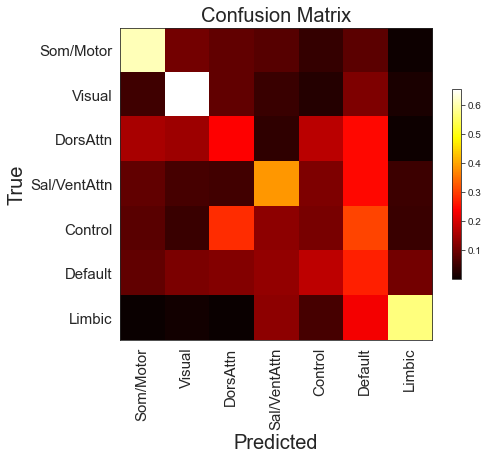

In [33]:
ConfusionMat(clf_test,clf_pred_Both,'ConfusionMatrix_Ensembled_left')

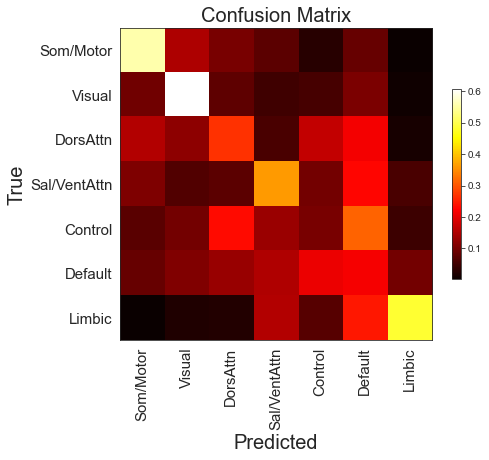

In [34]:
ConfusionMat(clf_test,clf_pred_DFC,'ConfusionMatrix_DFC_left')

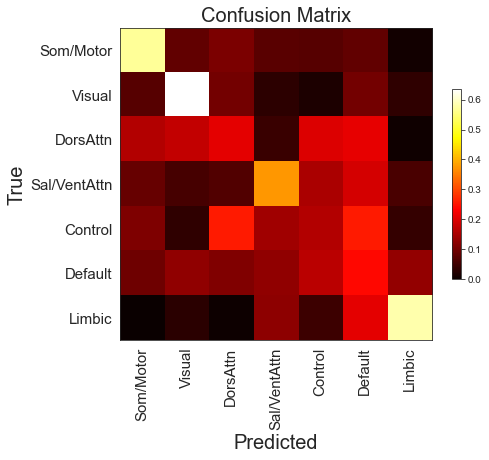

In [35]:
ConfusionMat(clf_test,clf_pred_VIS,'ConfusionMatrix_VIS_left')

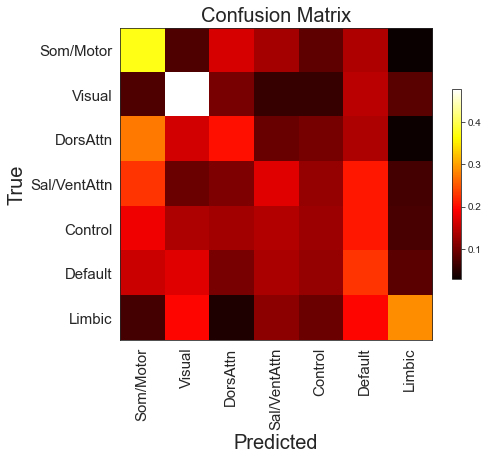

In [36]:
ConfusionMat(spin_test,spin_pred_Both,'ConfusionMatrix_Ensembled_Spin_left')

#### surface plot

In [93]:
clf_num = 1000
parcel_num = 191
test_parcel_num = 58
net_num = 7

pacc_left_DFC,pacc_left_VIS,pacc_left_Both,pnull_left_DFC,pnull_left_VIS,pnull_left_Both = ParcelAccuracy(clf_num, parcel_num, test_parcel_num, net_num, 
                                                                                                          schaefer400_7Networks_mat_left, 
                                                                                                          clf_pred_DFC, clf_pred_VIS, clf_pred_Both,clf_sample_test,
                                                                                                          spin_pred_DFC, spin_pred_VIS, spin_pred_Both,spin_sample_test)


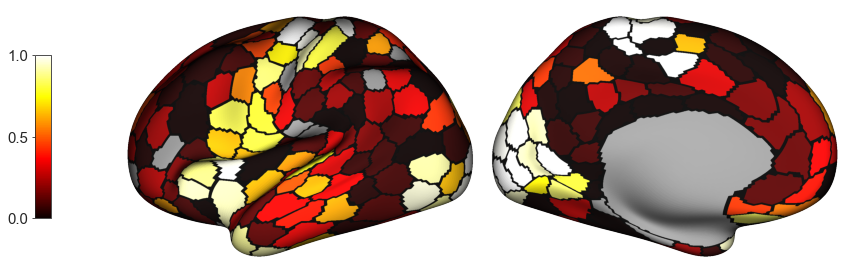

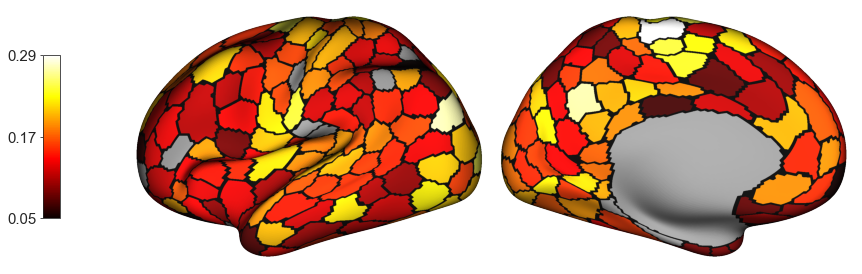

In [94]:
SurfPlot_left(pacc_left_DFC, LakeDFC_schaefer400, 'ParcelAccuracy_SurfPlot_DFC_left')
SurfPlot_left(pnull_left_DFC, LakeDFC_schaefer400, 'ParcelAccuracyNull_SurfPlot_DFC_left')

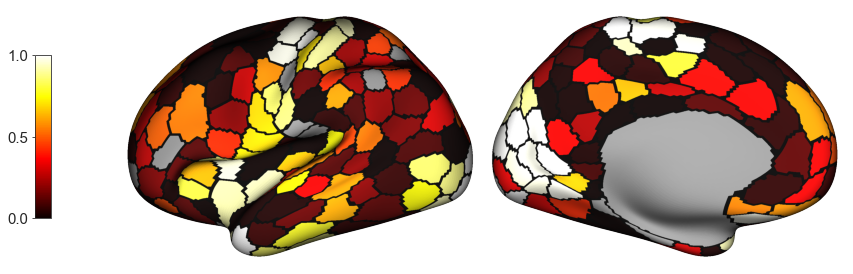

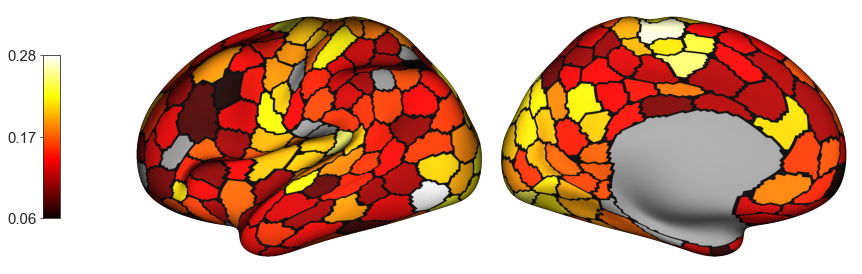

In [95]:
SurfPlot_left(pacc_left_VIS, LakeDFC_schaefer400, 'ParcelAccuracy_SurfPlot_VIS_left')
SurfPlot_left(pnull_left_VIS, LakeDFC_schaefer400, 'ParcelAccuracyNull_SurfPlot_VIS_left')

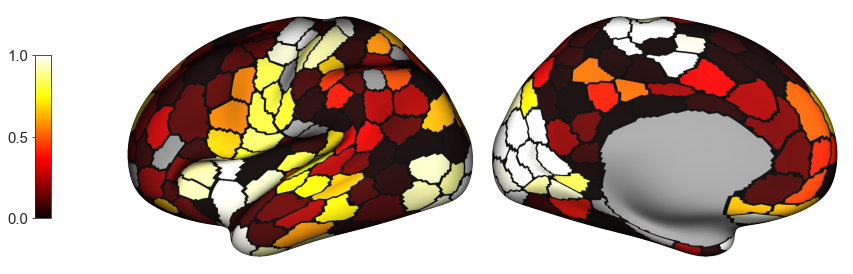

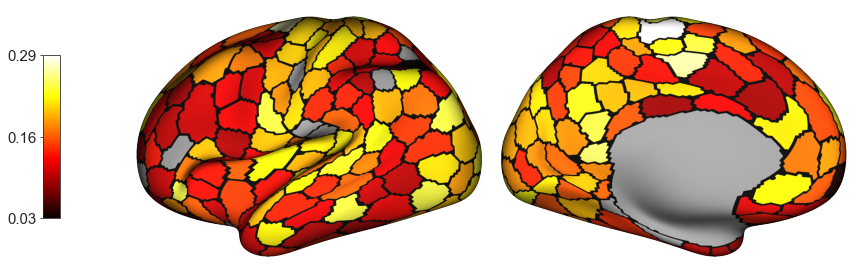

In [96]:
SurfPlot_left(pacc_left_Both, LakeDFC_schaefer400, 'ParcelAccuracy_SurfPlot_Ensembled_left')
SurfPlot_left(pnull_left_Both, LakeDFC_schaefer400, 'ParcelAccuracyNull_SurfPlot_Ensembled_left')

## Both Hemispheres

In [17]:
# load the results
clf_test, clf_sample_test, clf_pred_Both , clf_score_Both, clf_recall_Both, clf_pred_DFC, clf_score_DFC, clf_recall_DFC, C_best_DFC, gamma_best_DFC, kernel_best_DFC, degree_best_DFC, clf_pred_VIS, clf_score_VIS, clf_recall_VIS, C_best_VIS, gamma_best_VIS, kernel_best_VIS, degree_best_VIS = pickle.load(open(net_enrich_dir+'/1000ClassifiersBalancedEnsembled_Full_2.pkl',"rb"))
# load the nulls
spin_test, spin_sample_test, spin_pred_Both, spin_score_Both, spin_recall_Both, spin_pred_DFC, spin_score_DFC, spin_recall_DFC, spin_pred_VIS, spin_score_VIS, spin_recall_VIS = pickle.load(open(net_enrich_dir+'/1000NullsBalancedSpinEnsembeled_Full_2.pkl',"rb"))

perm_test, perm_sample_test, perm_pred_Both, perm_score_Both, perm_recall_Both, perm_pred_DFC, perm_score_DFC, perm_recall_DFC, perm_pred_VIS, perm_score_VIS, perm_recall_VIS = pickle.load(open(net_enrich_dir+'/1000NullsBalancedPermEnsembeled_Full.pkl',"rb"))


### Over all performance: f-1 macro score

In [16]:
# p-value for performance
p_null_DFC = get_null_p(np.asarray(clf_score_DFC),np.median(spin_score_DFC))
p_null_VIS = get_null_p(np.asarray(clf_score_VIS),np.median(spin_score_VIS))
p_null_Both = get_null_p(np.asarray(clf_score_Both),np.median(spin_score_Both))

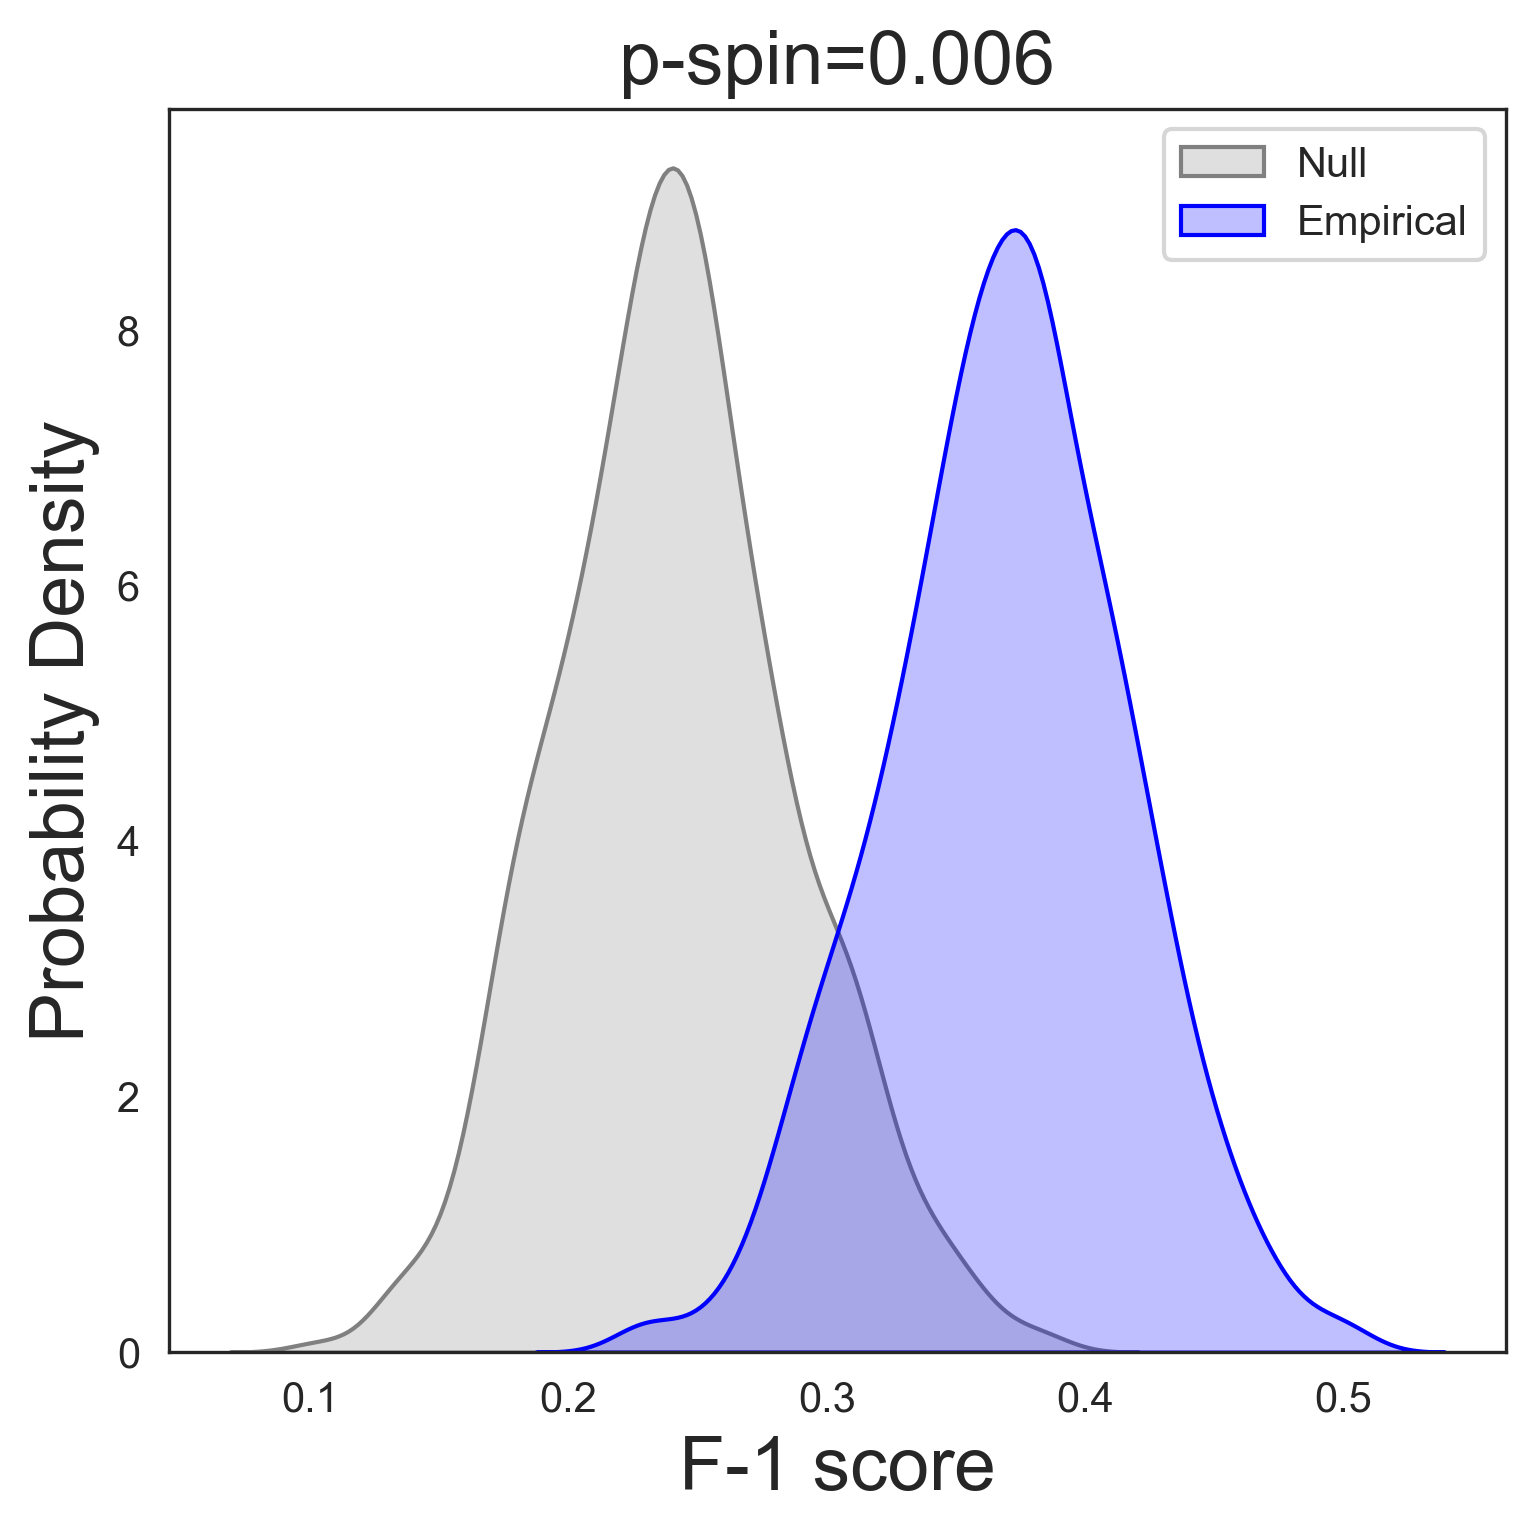

In [57]:
null = spin_score_DFC
clf = clf_score_DFC
p = p_null_DFC
fig_name = 'F1_DistPlot_DFC_spin'
F1DistPlot(null,clf,p,fig_name)

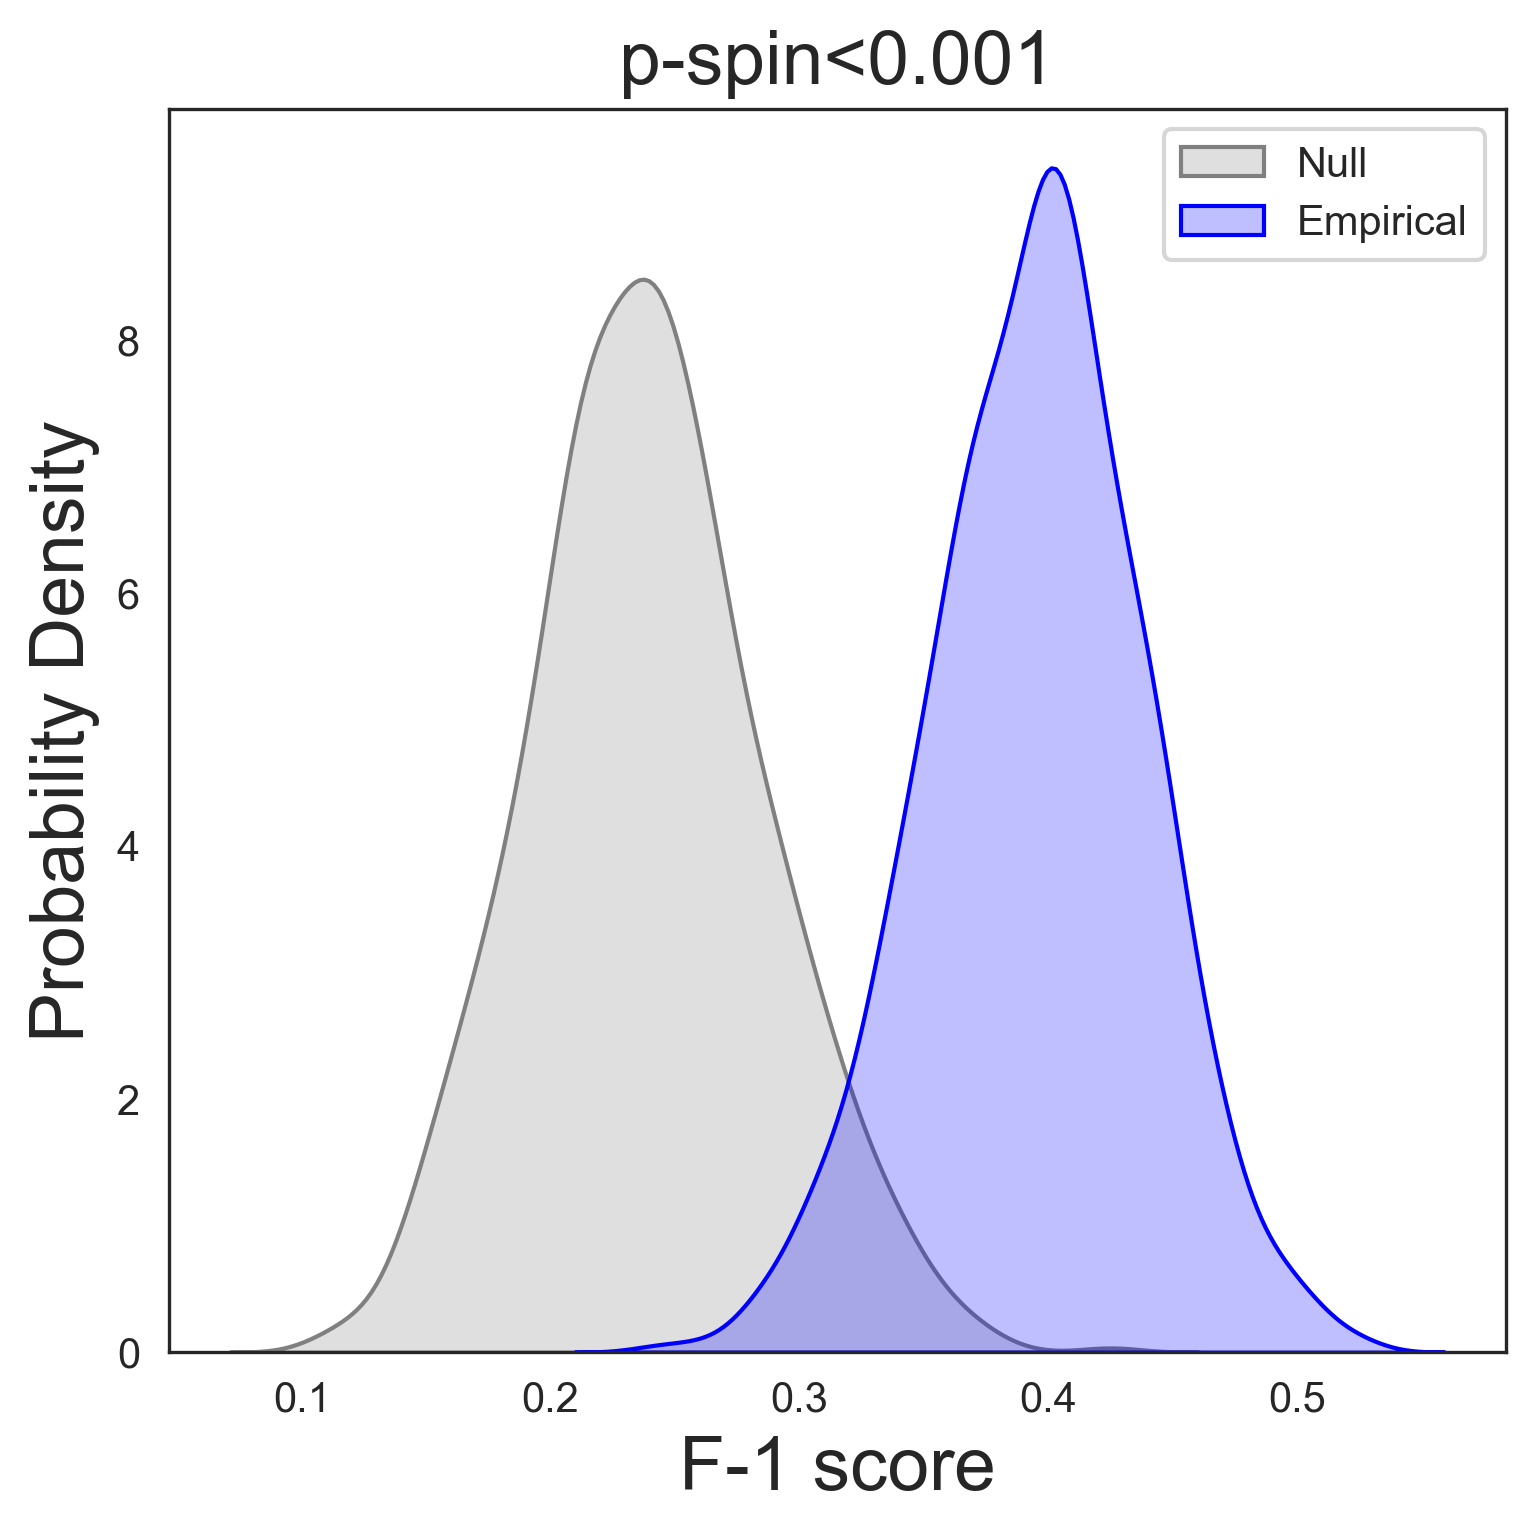

In [58]:
null = spin_score_VIS
clf = clf_score_VIS
p = p_null_VIS
fig_name = 'F1_DistPlot_VIS_spin'
F1DistPlot(null,clf,p,fig_name)

Null median 0.2520864695088635
Empirical median 0.4112474988830247


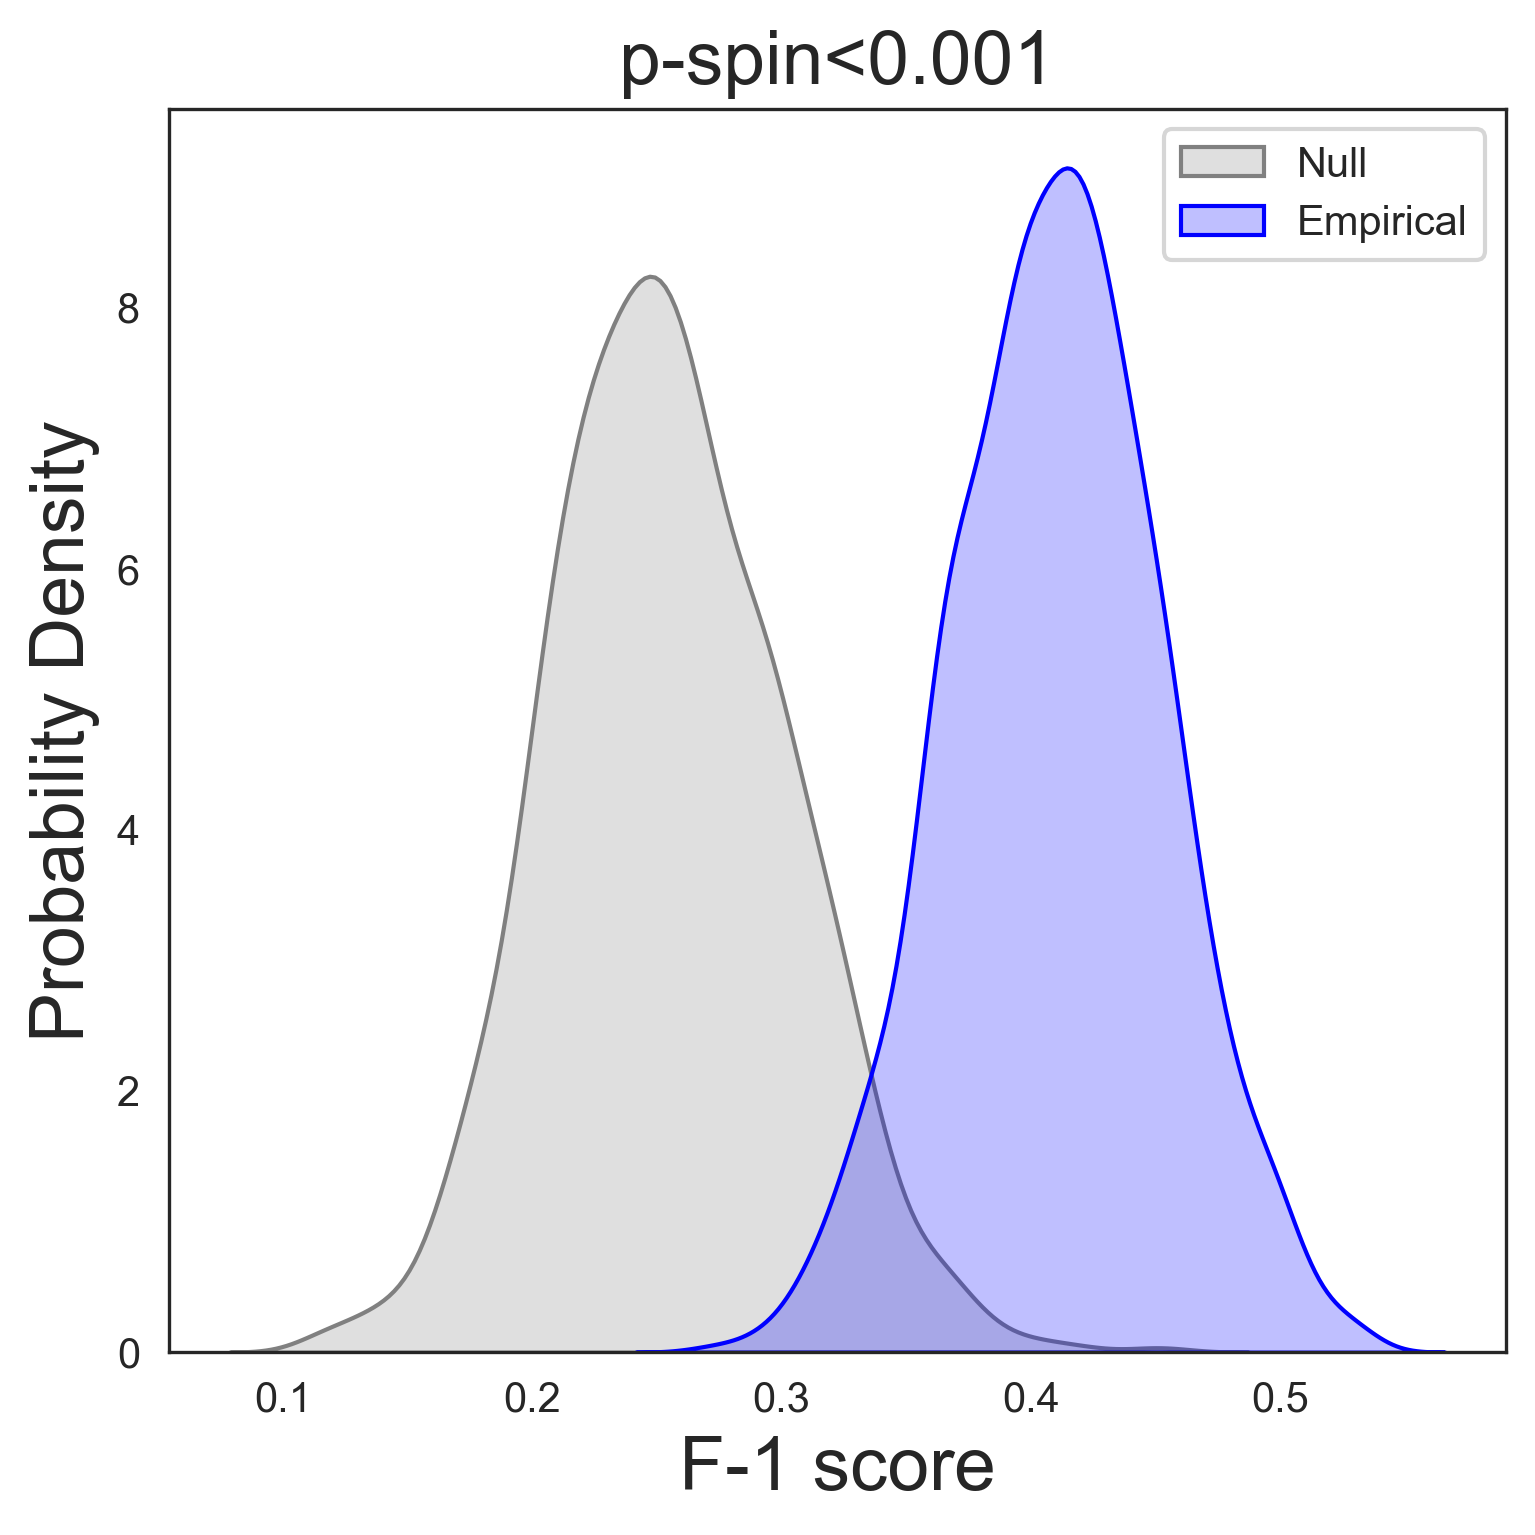

In [18]:
null = spin_score_Both
clf = clf_score_Both
print('Null median',np.median(null))
print('Empirical median',np.median(clf))
p = p_null_Both
fig_name = 'F1_DistPlot_Ensembled_spin'
F1DistPlot(null,clf,p,fig_name)

### Within network performance: recall

In [60]:
net_num = 7
perm_num = 1000

table_Both = Vec2Table_Recall(net_num, perm_num, clf_recall_Both, spin_recall_Both)
table_DFC = Vec2Table_Recall(net_num, perm_num, clf_recall_DFC, spin_recall_DFC)
table_VIS = Vec2Table_Recall(net_num, perm_num, clf_recall_VIS, spin_recall_VIS)

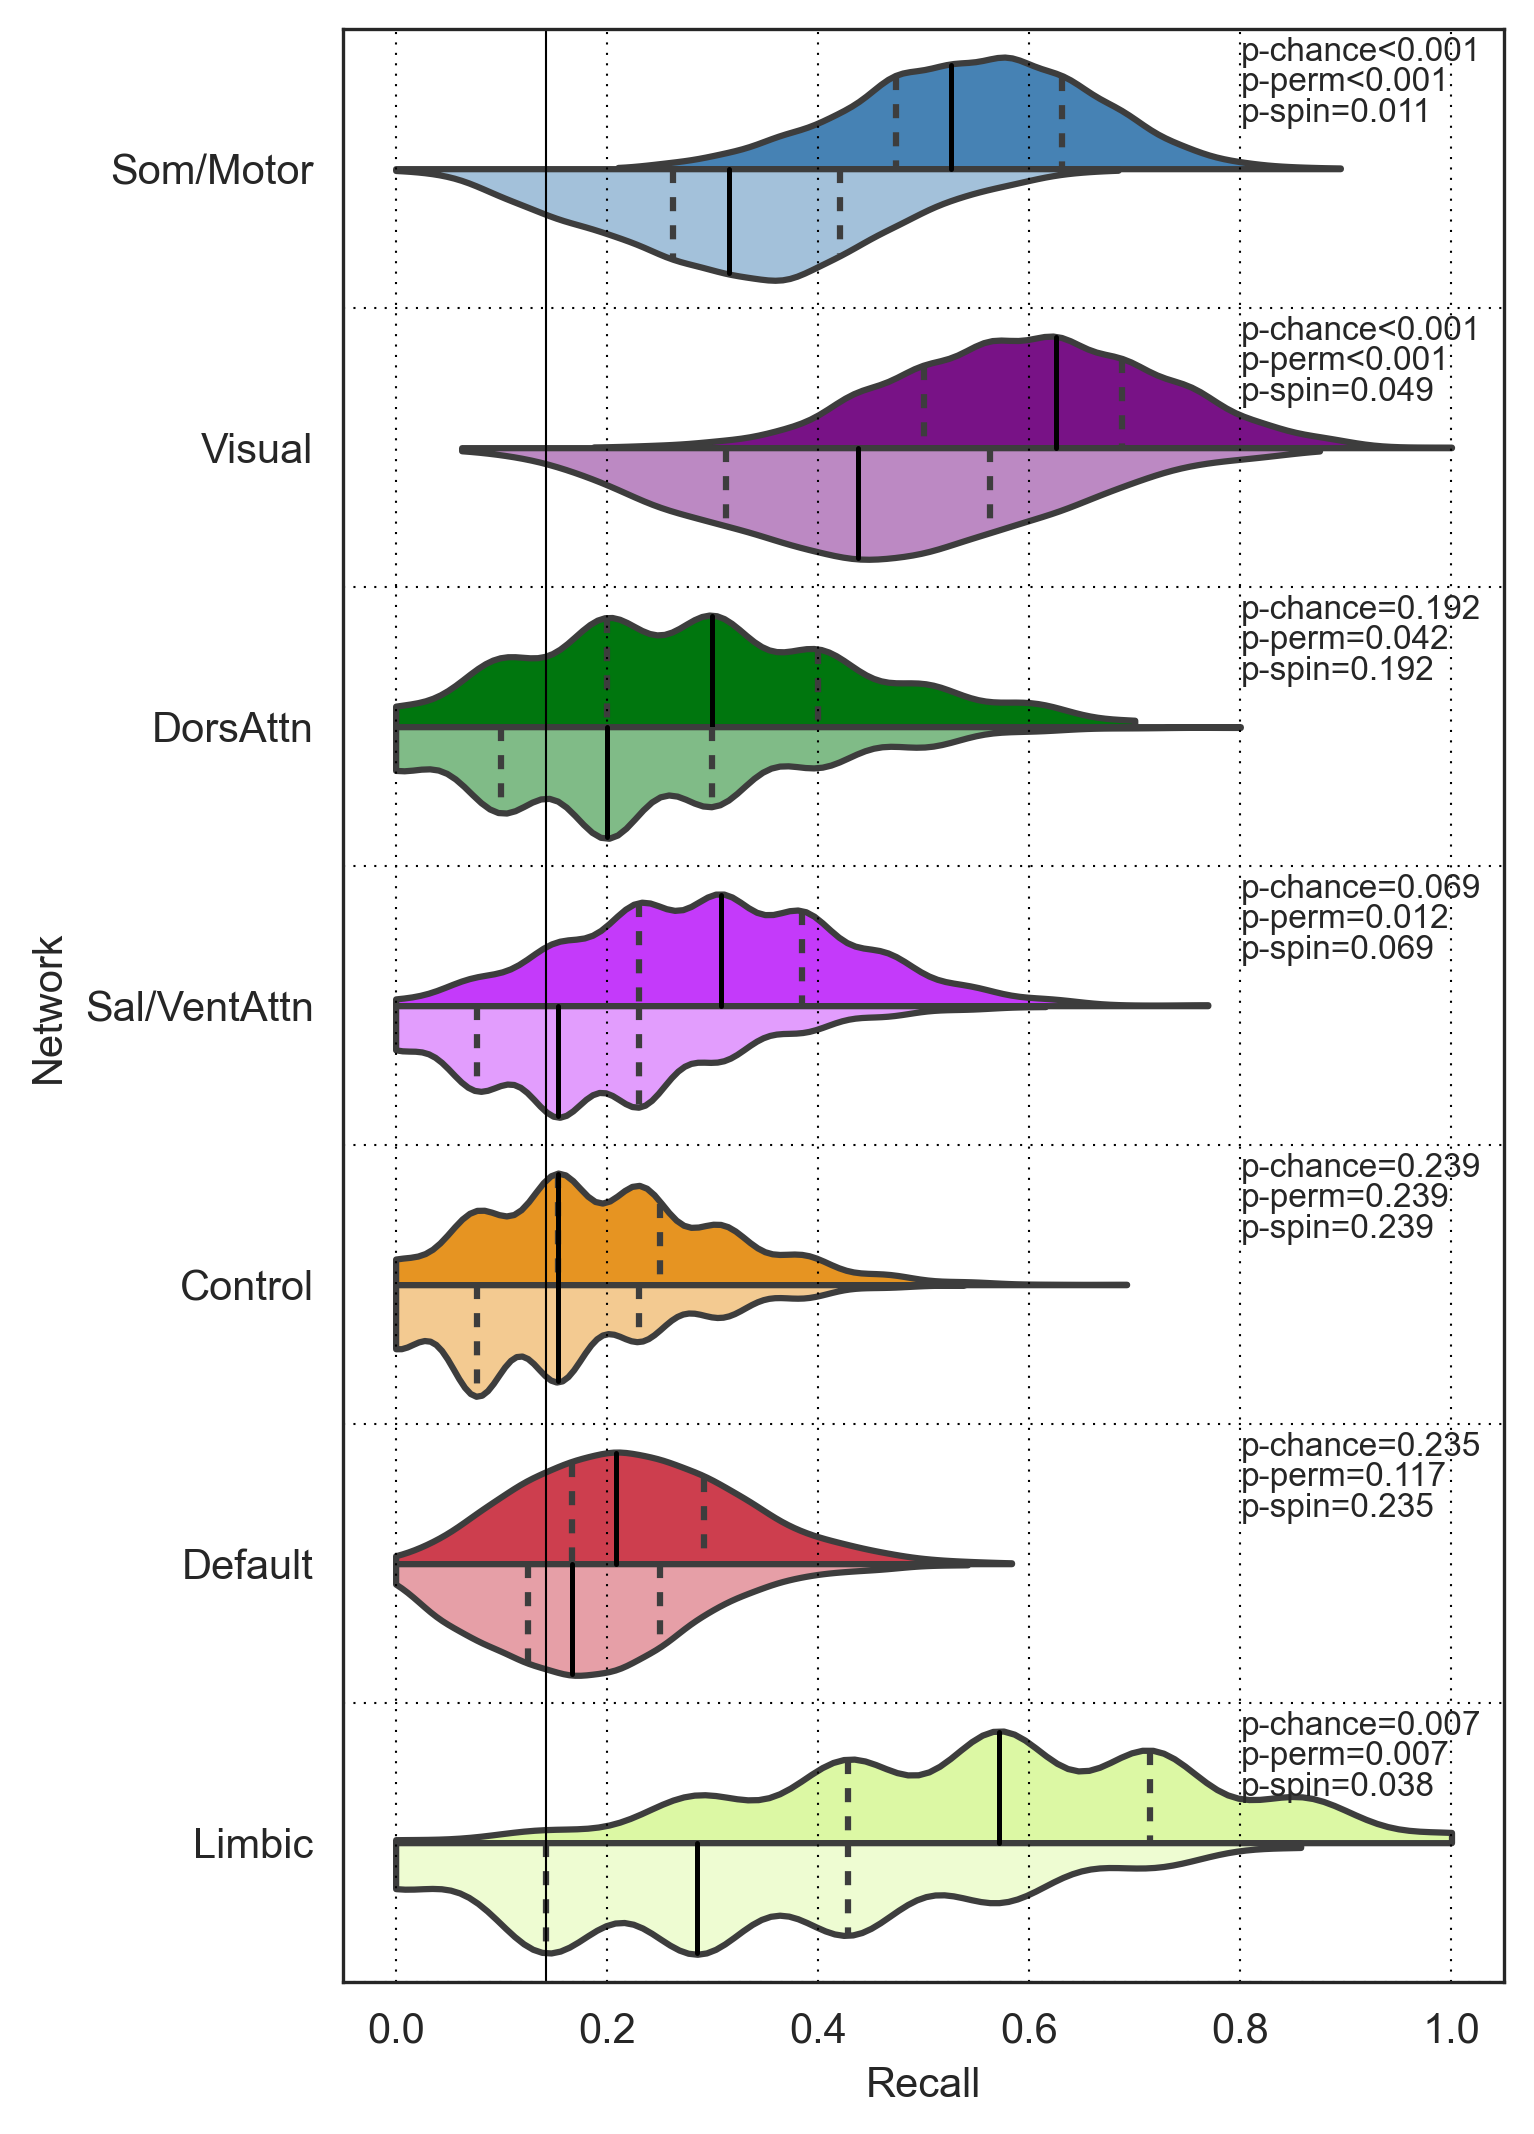

In [61]:
ViolinPlot_Recall_2(table_DFC,'Recall_ViolinPlot_DFC_spin',clf_recall_DFC,perm_recall_DFC,spin_recall_DFC)

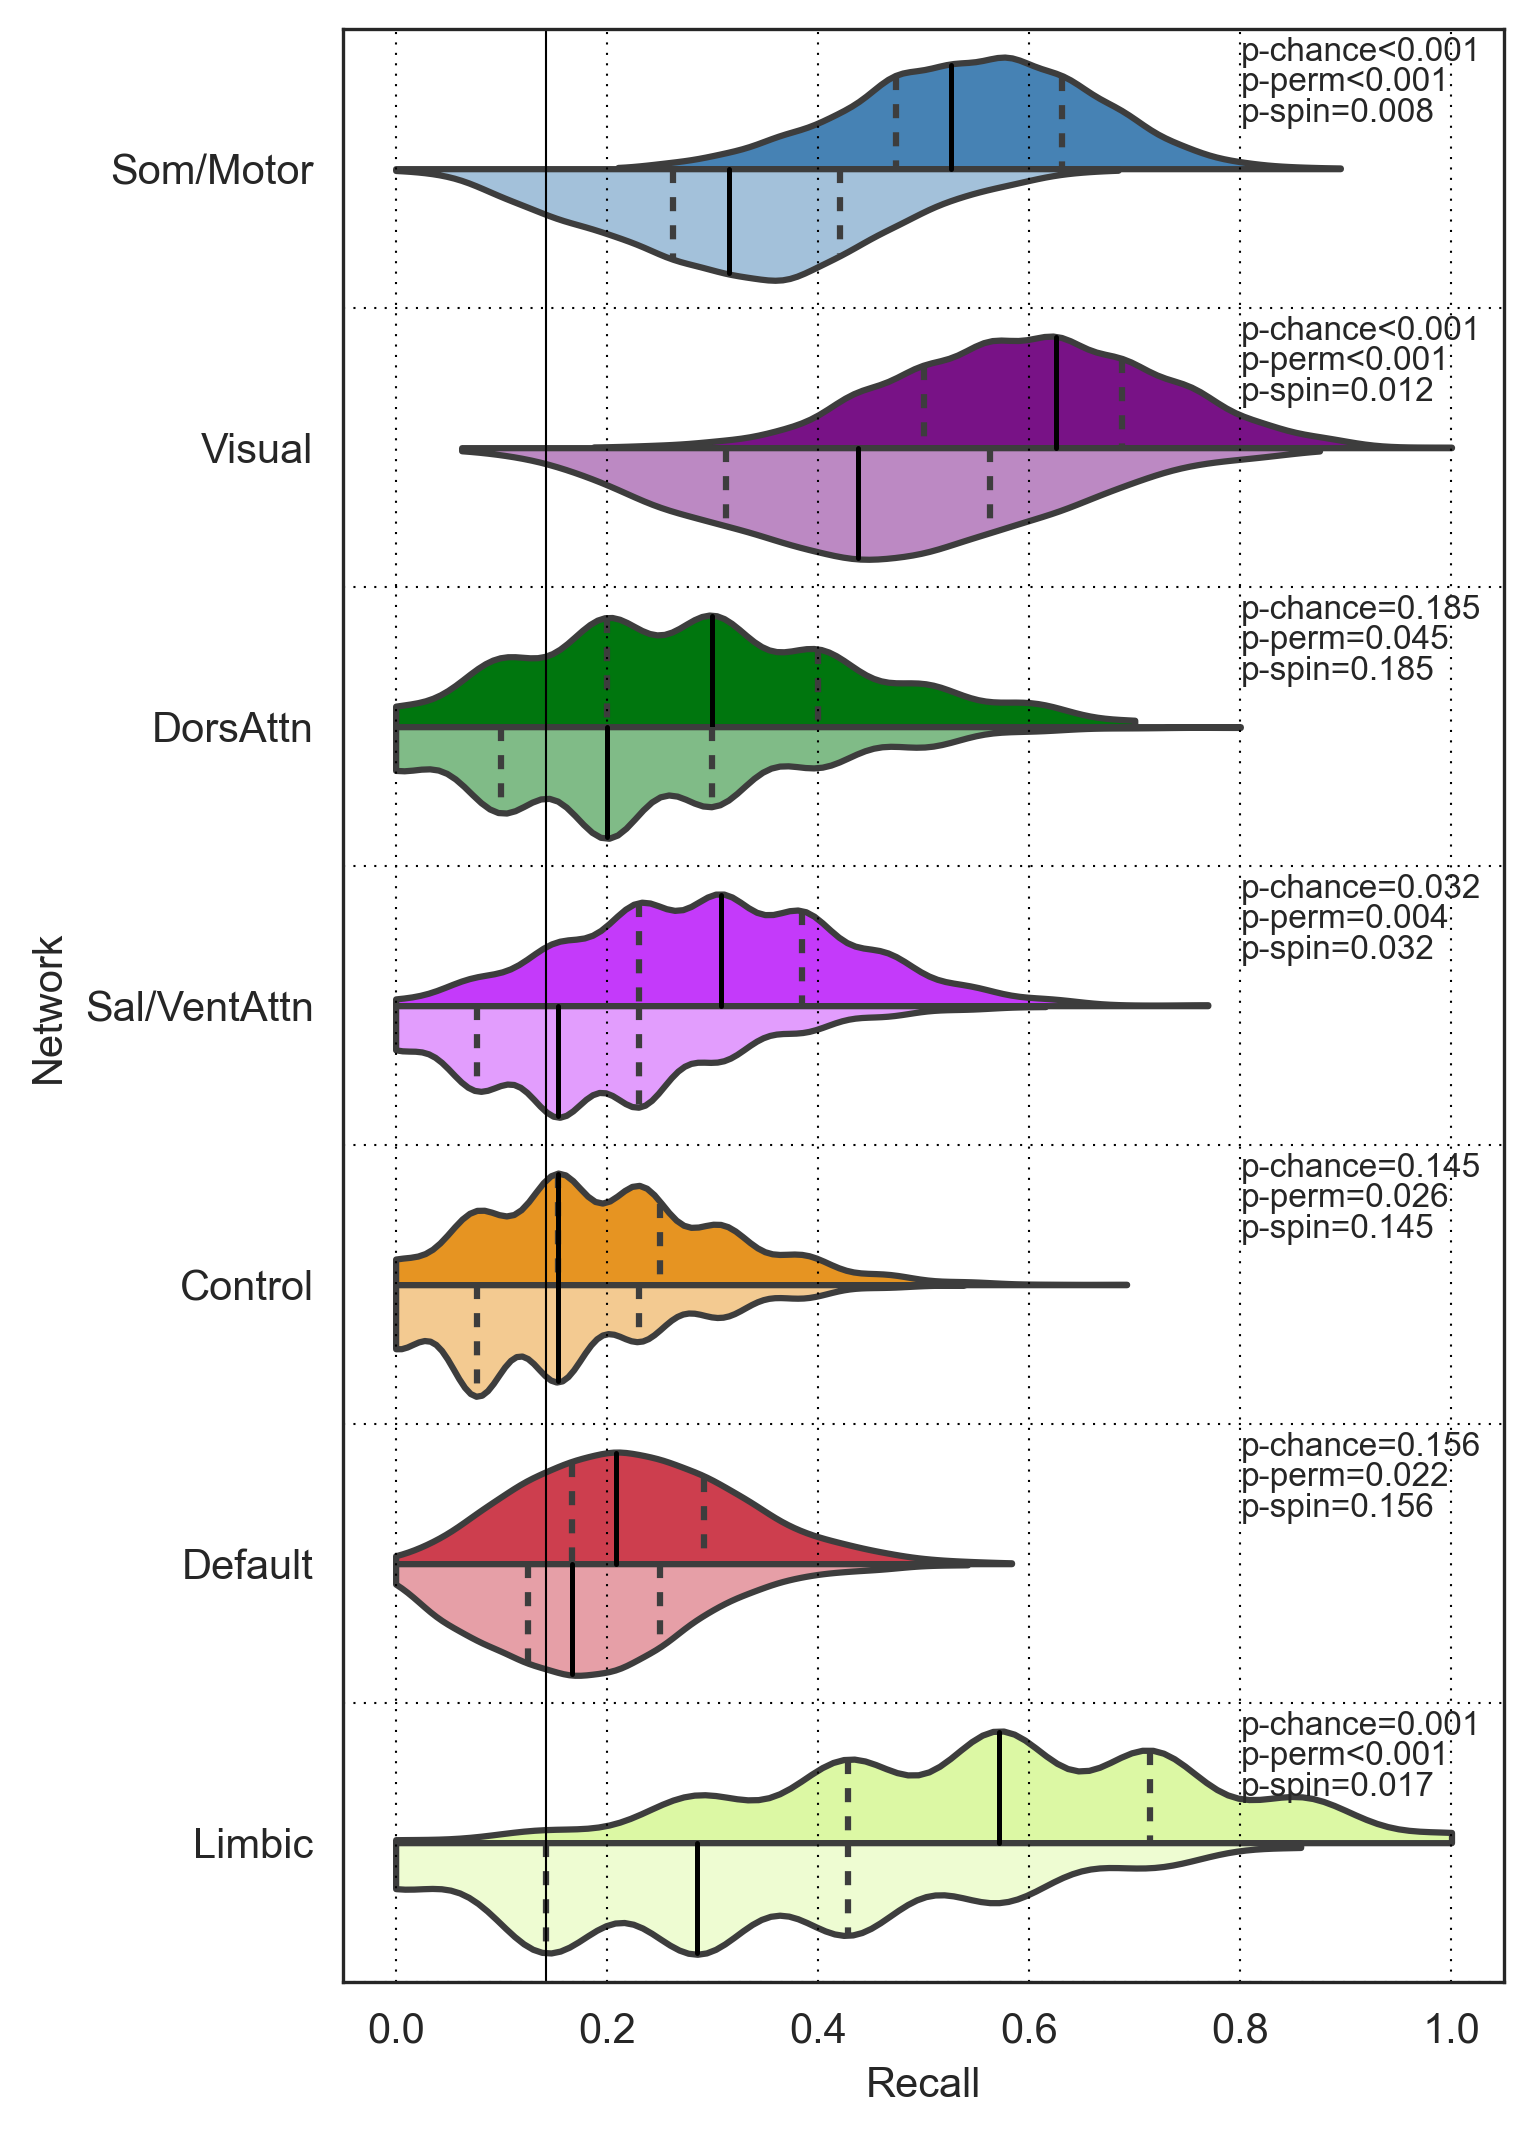

In [62]:
ViolinPlot_Recall_2(table_VIS,'Recall_ViolinPlot_VIS_spin',clf_recall_VIS,perm_recall_VIS,spin_recall_VIS)

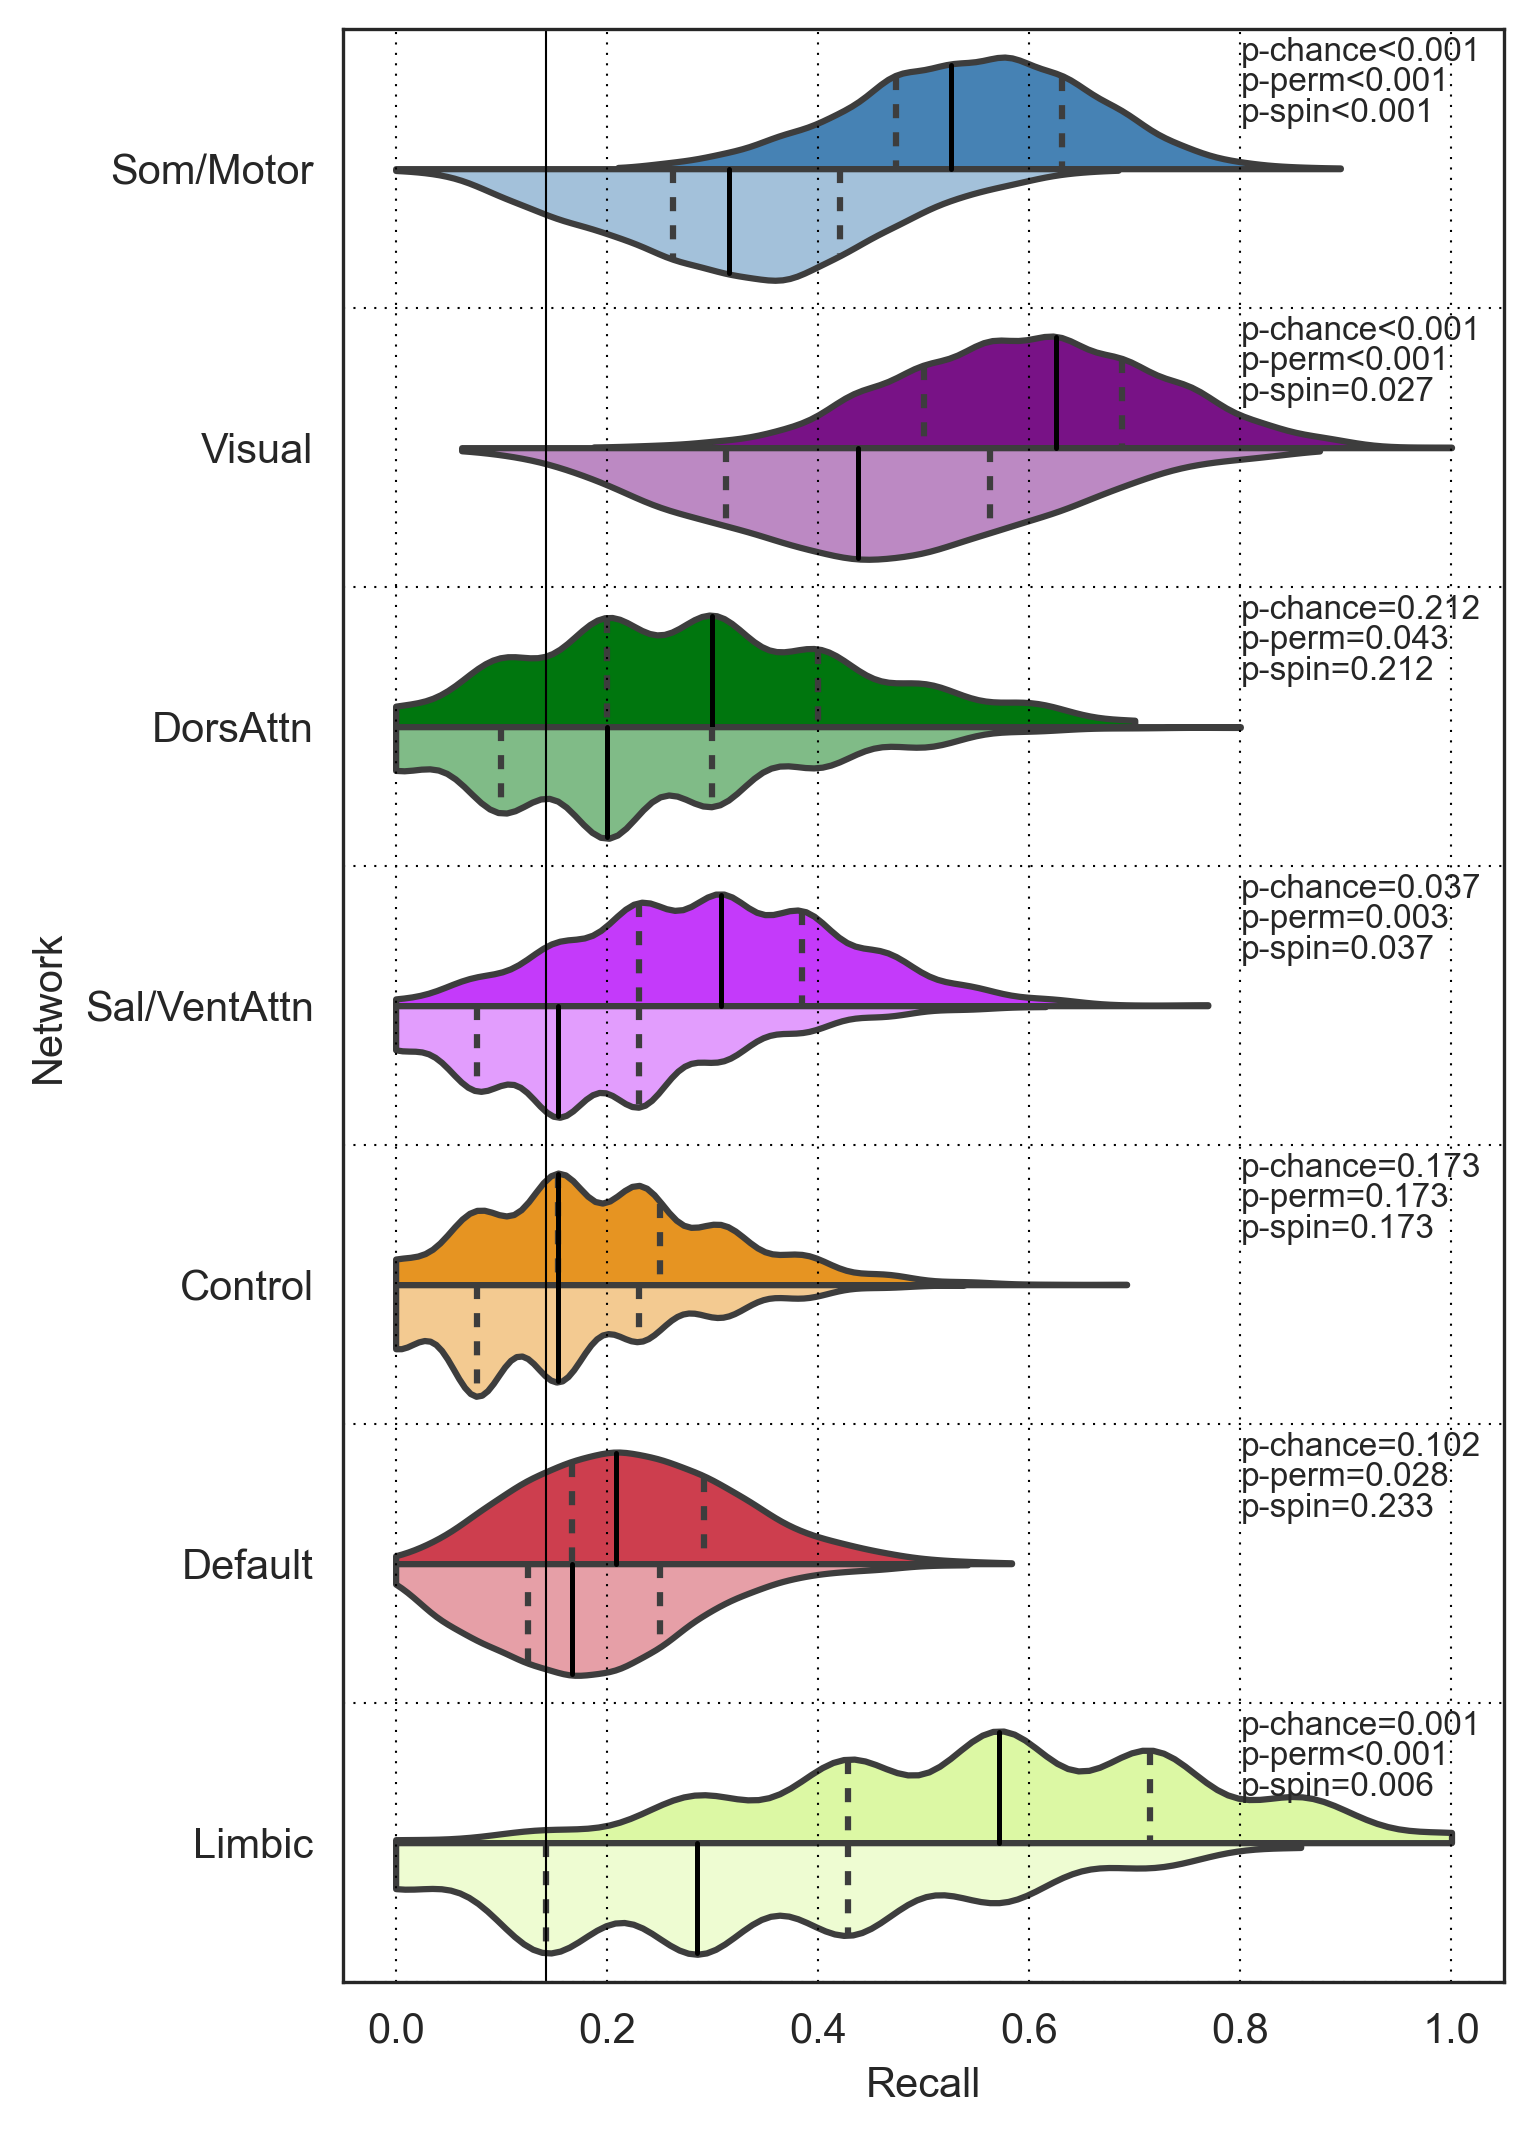

In [63]:
ViolinPlot_Recall_2(table_Both,'Recall_ViolinPlot_Ensembled_spin',clf_recall_Both,perm_recall_Both,spin_recall_Both)

### Parcel level accuracy
Use list to store all the predicted label for each parcel
#### Confusion matrix

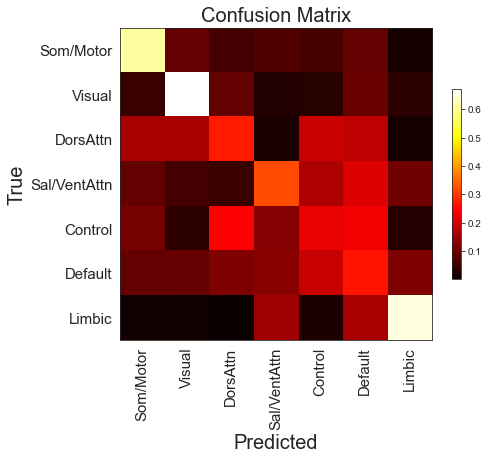

In [121]:
ConfusionMat(clf_test,clf_pred_Both,'ConfusionMatrix_Ensembled')

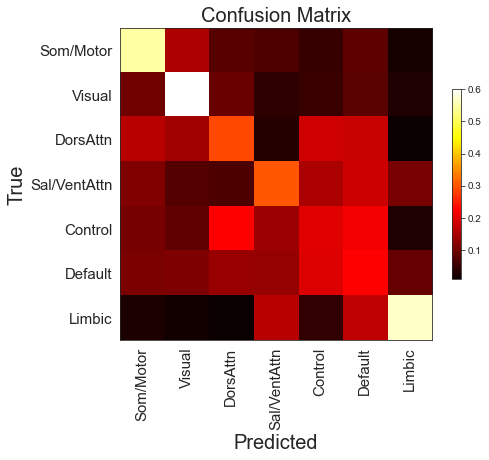

In [122]:
ConfusionMat(clf_test,clf_pred_DFC,'ConfusionMatrix_DFC')

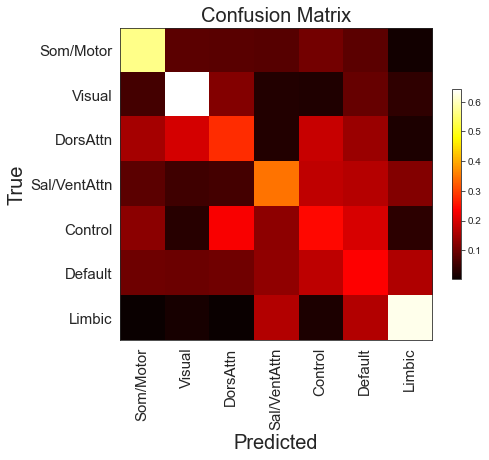

In [123]:
ConfusionMat(clf_test,clf_pred_VIS,'ConfusionMatrix_VIS')

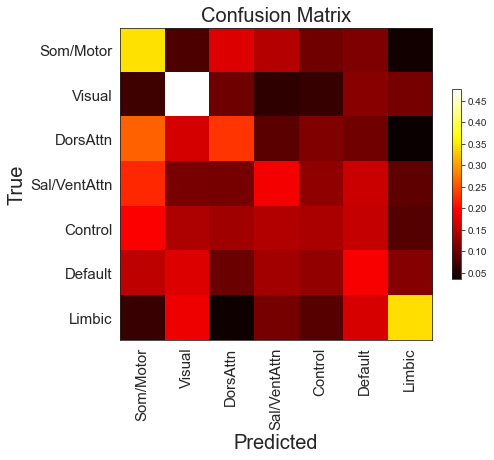

In [124]:
ConfusionMat(spin_test,spin_pred_Both,'ConfusionMatrix_Ensembled_spin')

#### Surface Plot

In [18]:
clf_num = 1000
parcel_num = 339
test_parcel_num = 102
net_num = 7

pacc_full_DFC,pacc_full_VIS,pacc_full_Both,pnull_full_DFC,pnull_full_VIS,pnull_full_Both = ParcelAccuracy(clf_num, parcel_num, test_parcel_num, net_num, 
                                                                                                          schaefer400_7Networks_mat, 
                                                                                                          clf_pred_DFC, clf_pred_VIS, clf_pred_Both,clf_sample_test,
                                                                                                          spin_pred_DFC, spin_pred_VIS, spin_pred_Both,spin_sample_test)


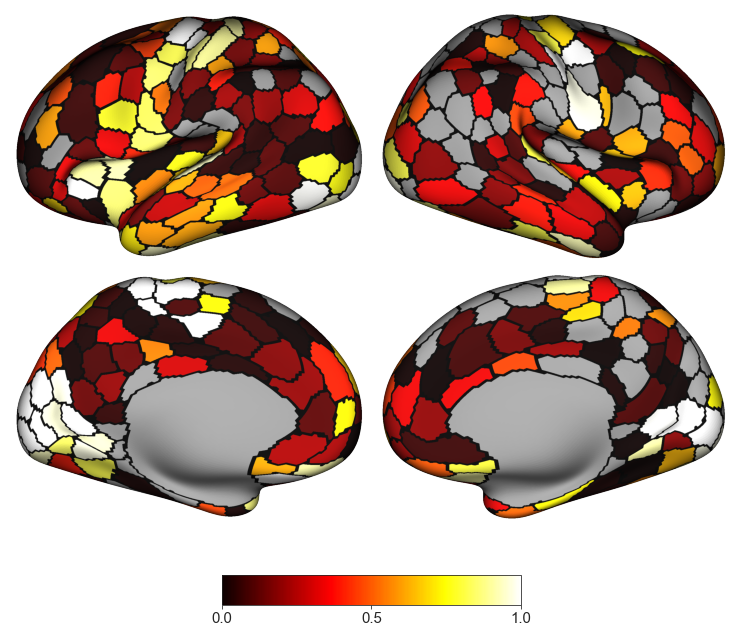

In [73]:
SurfPlot_full(pacc_full_DFC, LakeDFC_schaefer400, 'ParcelAccuracy_SurfPlot_DFC')

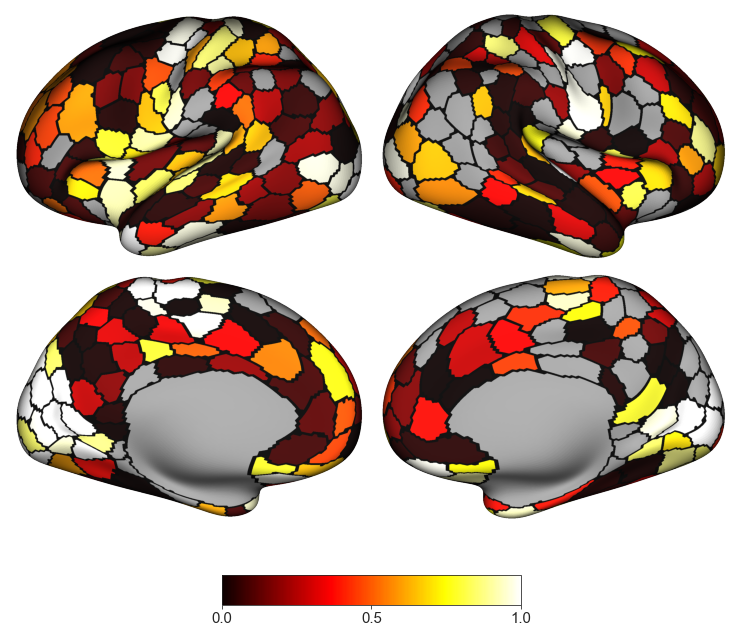

In [74]:
SurfPlot_full(pacc_full_VIS, LakeDFC_schaefer400, 'ParcelAccuracy_SurfPlot_VIS')

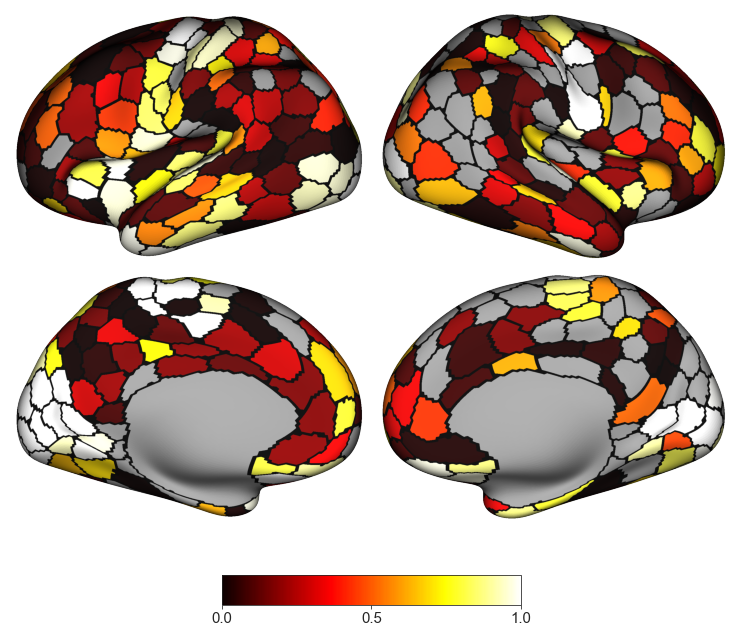

In [42]:
pars = SurfPlot_full(pacc_full_Both, LakeDFC_schaefer400, 'ParcelAccuracy_SurfPlot_Ensembled')

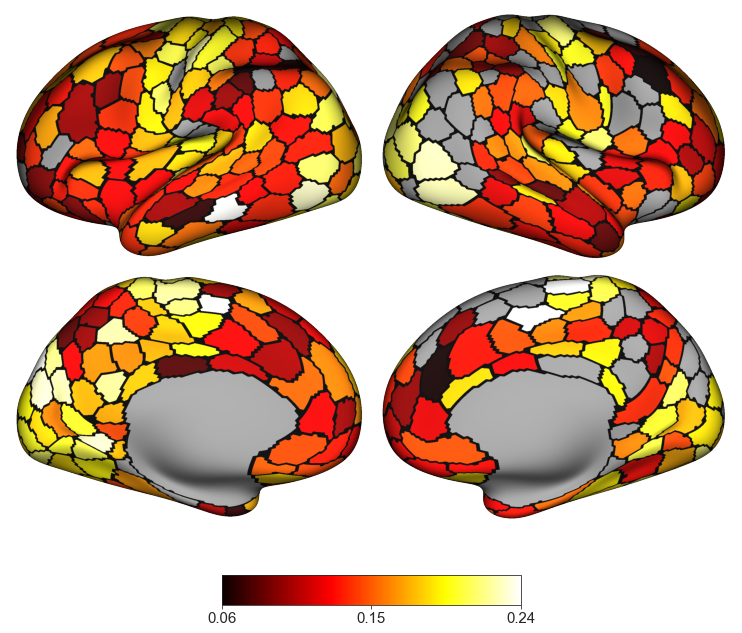

In [76]:
SurfPlot_full(pnull_full_Both, LakeDFC_schaefer400, 'ParcelAccuracySpin_SurfPlot_Ensembled')

In [19]:
df = WithinNetworkParcelAccuracyStats(pacc_full_Both,schaefer400_7Networks_drop['1'],'ParcelAccuracy_NetworkStats_Ensembled')
df

networks      mean       max       min       std
labels                                                      
1             Visual  0.674352  1.000000  0.000000  0.389939
2          Som/Motor  0.604534  1.000000  0.000000  0.390318
3           DorsAttn  0.270541  0.788779  0.007117  0.238251
4       Sal/VentAttn  0.322817  0.990654  0.000000  0.350503
5             Limbic  0.654105  1.000000  0.000000  0.370962
6            Control  0.225281  0.819079  0.000000  0.235787
7            Default  0.264442  0.863946  0.000000  0.245563

In [20]:
df = WithinNetworkParcelAccuracyStats(pnull_full_Both,schaefer400_7Networks_drop['1'],'ParcelAccuracySpin_NetworkStats_Ensembled')
df

networks      mean       max       min       std
labels                                                      
1             Visual  0.194949  0.242525  0.126712  0.027577
2          Som/Motor  0.193642  0.244604  0.138408  0.024413
3           DorsAttn  0.138394  0.212625  0.080997  0.029024
4       Sal/VentAttn  0.133883  0.180602  0.093750  0.019108
5             Limbic  0.137373  0.189189  0.068100  0.029441
6            Control  0.109339  0.189441  0.056856  0.034523
7            Default  0.148164  0.243421  0.066445  0.036653